            Projet n°5 Catégorisez automatiquement des questions


Nous allons dans cette étude proposez une analyse textuelle des questions posées sur le site Stackoverflow. Notre objectif final est de suggérer des tags relatifs à la question posée afin d'aider les débutants dans leurs premiers pas sur le site.

Ce notebook représente l'analyse exploratoire des données

- <a href="#C1">1. Importation des données
- <a href="#C2">2. Analyse des données
    - <a href="#C2.1">2.1 Structure      
    - <a href="#C2.2">2.2 Champs vides et dupliqués  
    - <a href="#C2.3">2.3 Analyse univariée
    - <a href="#C2.4">2.4 Analyse multivariée
- <a href="#C3">3. Réduction des Posts
    - <a href="#C3.1">3.1 Nettoyage du code dans le corps du post
    - <a href="#C3.2">3.2 Nettoyage des Posts
        - <a href="#C3.2.1">3.2.1 Initialisation
        - <a href="#C3.2.2">3.2.2 Traitement de l'ensemble du corpus
        - <a href="#C3.2.3">3.2.3 Nettoyage des textes et des Tags
    - <a href="#C3.3">3.3 Analyse textuelle
        - <a href="#C3.3.1">3.3.1 Représentation visuelle
        - <a href="#C3.3.2">3.3.2 Analyse de la distribution des tokens
        - <a href="#C3.3.3">3.3.3 Nettoyage aprés analyse
- <a href="#C4">4. Sauvegarde du jeu de données nettoyé    


In [1]:
import os, sys, time
import numpy as np
import pandas as pd

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import re
#from bs4 import BeautifulSoup

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import words

#from guesslang import Guess

from pandarallel import pandarallel

In [2]:
# Download
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('words')

[nltk_data] Downloading package omw-1.4 to /Users/claude/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/claude/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/claude/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /Users/claude/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [3]:
sns.set()
pandarallel.initialize(progress_bar=True, nb_workers=4, verbose=1)

# <a name="C1">1. Importation des données</a>

In [4]:
path="./data/source/"
os.listdir(path)

['.DS_Store',
 'glove.42B.300d.txt',
 'glove.6B.100d.txt',
 'enwiki_20180420_100d.txt.bz2',
 'QueryResults1.csv',
 'QueryResults2.csv',
 'word2vec model SO_vectors_200.bin']

In [5]:
#import warnings
#warnings.filterwarnings('ignore')
df = pd.DataFrame()
data1 = path + "QueryResults1.csv"
data2 = path + "QueryResults2.csv"
df_part1 = pd.read_csv(data1, index_col =0,encoding = 'latin1') 
df_part2 = pd.read_csv(data2, index_col =0,encoding = 'latin1') 
df = pd.concat([df_part1, df_part2], axis=0)

In [6]:
df.sample(10)

,Title,Body,Tags,Score,ViewCount,FavoriteCount,AnswerCount
Id,,,,,,,
75871883,Rust formatting Ipv6 Address,<p>I am trying understand how Ipv6 formatting ...,<rust><formatting><ipv6>,0,46,NaN,0
75786133,GA4 - Bigquery: How to get events by removing ...,<p>I have a landing page and a button download...,<firebase><google-bigquery><google-analytics>,0,49,NaN,0
75713896,Generate list of regression models (looping ov...,<p>The aim of this exercise is to have a list ...,<r>,0,28,NaN,0
75662191,"Django Reverse for '...' with arguments '('', ...",<p>Help is needed. I have tried many solutions...,<django>,-1,46,NaN,2
75774726,How could I properly Collect a Set<String> by ...,<p>I think I can make this simplier but can no...,<java><java-stream>,0,44,NaN,1
75610695,Kubernetes informer fails with Unauthorized,<p>I'm trying to construct a Kubernetes inform...,<kubernetes><amazon-eks><client-go><aws-iam-au...,1,56,NaN,1
75696770,mosaic plot with two variables,<p>This time i am struggling with plotting a m...,<r><mosaic-plot><r-mosaic>,0,33,NaN,1
75635355,C++ how to std::accumulate vector of futures?,<p>Why following code does not compile?</p>\n<...,<c++><concurrency><future>,2,73,NaN,1
75865512,Python access to sharepoint online folder with...,<p>I need to read in python an excel saved in ...,<python><sharepoint><office365>,0,22,NaN,0


# <a name="C2">2. Analyse des données</a>

## <a name="C2.1">2.1 Structure</a>

In [7]:
df.shape

(100000, 7)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 75598427 to 75871260
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Title          100000 non-null  object 
 1   Body           100000 non-null  object 
 2   Tags           100000 non-null  object 
 3   Score          100000 non-null  int64  
 4   ViewCount      100000 non-null  int64  
 5   FavoriteCount  8 non-null       float64
 6   AnswerCount    100000 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 6.1+ MB


In [9]:
df.dtypes.value_counts()

object     3
int64      3
float64    1
dtype: int64

In [10]:
df.nunique()

Title            99988
Body             99997
Tags             71932
Score               38
ViewCount          570
FavoriteCount        1
AnswerCount         11
dtype: int64

In [11]:
tmp = df.nunique()
tmp

Title            99988
Body             99997
Tags             71932
Score               38
ViewCount          570
FavoriteCount        1
AnswerCount         11
dtype: int64

In [12]:
tmp[tmp<10]

FavoriteCount    1
dtype: int64

In [13]:
tmp[tmp>100]

Title        99988
Body         99997
Tags         71932
ViewCount      570
dtype: int64

In [14]:
df.describe(include=np.number)

,Score,ViewCount,FavoriteCount,AnswerCount
count,100000.000000,100000.000000,8.0,100000.00000
mean,0.075100,44.973700,0.0,0.68235
std,1.863731,397.091052,0.0,0.78331
min,-10.000000,2.000000,0.0,0.00000
25%,0.000000,22.000000,0.0,0.00000
50%,0.000000,33.000000,0.0,1.00000
75%,0.000000,49.000000,0.0,1.00000
max,506.000000,104900.000000,0.0,11.00000


In [15]:
df.describe(include=object)

,Title,Body,Tags
count,100000,100000,100000
unique,99988,99997,71932
top,ModuleNotFoundError: No module named,"<p>If i have a circle that rotates, and reach'...",<python>
freq,3,2,672


## <a name="C2.2">2.2 Champs vides et dupliqués</a>

In [16]:
df.isna().sum()

Title                0
Body                 0
Tags                 0
Score                0
ViewCount            0
FavoriteCount    99992
AnswerCount          0
dtype: int64

In [17]:
df.isna().mean()

Title            0.00000
Body             0.00000
Tags             0.00000
Score            0.00000
ViewCount        0.00000
FavoriteCount    0.99992
AnswerCount      0.00000
dtype: float64

In [18]:
df.isna().mean().sort_values()

Title            0.00000
Body             0.00000
Tags             0.00000
Score            0.00000
ViewCount        0.00000
AnswerCount      0.00000
FavoriteCount    0.99992
dtype: float64

<AxesSubplot:ylabel='Id'>

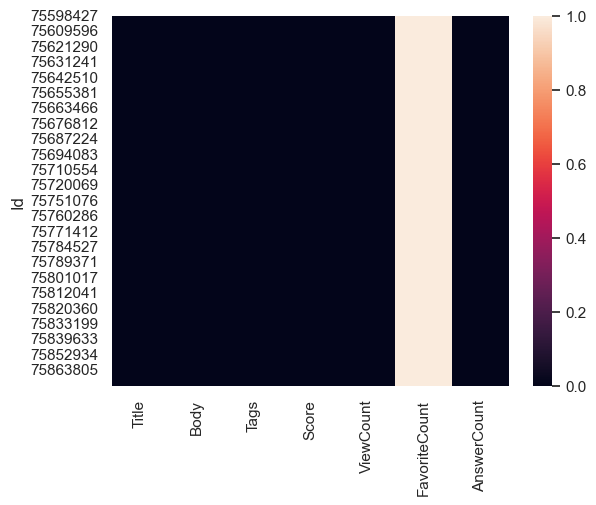

In [19]:
sns.heatmap(df.isna())

In [20]:
df.duplicated().sum()

0

In [21]:
df.columns

Index(['Title', 'Body', 'Tags', 'Score', 'ViewCount', 'FavoriteCount',
       'AnswerCount'],
      dtype='object')

In [22]:
df.Title.duplicated().sum()

12

In [23]:
idx = df.duplicated(subset='Title',keep=False)
df.loc[idx,].sort_values("Title")

,Title,Body,Tags,Score,ViewCount,FavoriteCount,AnswerCount
Id,,,,,,,
75771929,Error when launching the app for the second ti...,<p>I have an application in react native that ...,<storage><database><android><export><sqlite>,0,19,NaN,0
75761051,Error when launching the app for the second ti...,<p>I have an application in react native that ...,<database><react-native><sqlite><expo><typeorm>,1,22,NaN,0
75798572,How do I auto tabulate the Column in B and C o...,<p>How do I auto tabulate the Column in B and ...,<string><google-sheets><count><duplicates><tab...,0,27,NaN,0
75790496,How do I auto tabulate the Column in B and C o...,<p>How do I auto tabulate the Column in B and ...,<duplicates><automated-tests>,0,11,NaN,0
75948497,How to optimize a UDP socket for packet forwar...,<p>I'm doing packet forwarding through the use...,<networking><sockets><udp>,0,34,NaN,1
75859673,How to optimize a UDP socket for packet forwar...,<p>I'm doing packet forwarding through the use...,<c><sockets><networking><udp>,0,60,NaN,1
75776446,Is there a way to find uptime of legacy virtua...,<p>Is there a way to find uptime of legacy vir...,<batch-file><automation><windows-xp><rdp><uptime>,0,23,NaN,0
75780462,Is there a way to find uptime of legacy virtua...,<p>Is there a way to find uptime of legacy vir...,<batch-file><automation><windows-xp><rdp><uptime>,-1,10,NaN,0
75720308,ModuleNotFoundError: No module named,<p>Why when I try to import my file I get erro...,<python>,-2,18,NaN,0


In [24]:
df.Body.duplicated().sum()

3

In [25]:
idx = df.duplicated(subset='Body',keep=False)
df.loc[idx,].sort_values("Body")

,Title,Body,Tags,Score,ViewCount,FavoriteCount,AnswerCount
Id,,,,,,,
75608489,how to concatenate the [CLS] token from BERT l...,<p>I want to concatenate the last layer [CLS] ...,<python><nlp><bert-language-model><tf-idf>,0,33,NaN,0
75647744,how to concatenate the [CLS] token from BERT l...,<p>I want to concatenate the last layer [CLS] ...,<python>,0,27,NaN,0
75771738,how to get the relative rotation in degrees ev...,"<p>If i have a circle that rotates, and reach'...",<javascript><jquery><css>,0,70,NaN,1
75773144,How to get the relative angle or degrees even ...,"<p>If i have a circle that rotates, and reach'...",<javascript><html><jquery><css>,-3,17,NaN,0
75623351,Your branch is ahead of 'origin/branch-A' by 1...,<p>This is a known problem on SO. The solution...,<git><git-branch>,-1,49,0.0,1
75623523,Your branch is ahead of 'origin/branch-A' by 1...,<p>This is a known problem on SO. The solution...,<git><git-branch>,0,27,0.0,0


In [26]:
# Drop NaN
df.isna().mean()

Title            0.00000
Body             0.00000
Tags             0.00000
Score            0.00000
ViewCount        0.00000
FavoriteCount    0.99992
AnswerCount      0.00000
dtype: float64

In [27]:
# Drop duplicated
idx = df.duplicated(subset='Title',keep='first')
df.loc[idx,].sort_values("Title")

,Title,Body,Tags,Score,ViewCount,FavoriteCount,AnswerCount
Id,,,,,,,
75771929,Error when launching the app for the second ti...,<p>I have an application in react native that ...,<storage><database><android><export><sqlite>,0,19,NaN,0
75798572,How do I auto tabulate the Column in B and C o...,<p>How do I auto tabulate the Column in B and ...,<string><google-sheets><count><duplicates><tab...,0,27,NaN,0
75859673,How to optimize a UDP socket for packet forwar...,<p>I'm doing packet forwarding through the use...,<c><sockets><networking><udp>,0,60,NaN,1
75780462,Is there a way to find uptime of legacy virtua...,<p>Is there a way to find uptime of legacy vir...,<batch-file><automation><windows-xp><rdp><uptime>,-1,10,NaN,0
75654622,ModuleNotFoundError: No module named,"<p>(<a href=""https://i.stack.imgur.com/TvwN3.p...",<module><scrapy>,1,33,NaN,0
75720308,ModuleNotFoundError: No module named,<p>Why when I try to import my file I get erro...,<python>,-2,18,NaN,0
75825370,Next.js Failed to load static props (with reac...,<p>I saw in sentry that many users experience ...,<reactjs><next.js><vercel><react-query><nextjs...,0,33,NaN,0
75805543,Python GUI client and server connection always...,<p>So my python program is essentially an inve...,<python><sockets><user-interface><tkinter><fre...,-1,30,NaN,0
75790634,Scaleratio plotly,<p>There is the following solution to the prob...,<python><plotly>,0,21,NaN,0


In [28]:
df.drop_duplicates(subset='Title', keep='first', inplace =True)

In [29]:
df.drop_duplicates(subset='Body', keep='first', inplace =True)

## <a name="C2.3">2.3 Analyse univariée</a>

In [30]:
def affiche_distribution(data, col):
    """
    Side by side displot and boxplot in order to show the distribution of each feature    

Args: 
        data: type DataFrame     Name of the dataframe         
        col: type (String)       Name of the column
        
    Returns:
    """
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
    
    sns.histplot(data=data, x=col, kde=True, ax=ax[0])
    ax[0].set_xlabel(f"{col}")
    ax[0].set_ylabel("Nombre d'observations")
    ax[0].set_title(f"Histograme de la variable {col}")
    
    sns.boxplot(data=data, x=col)
    ax[1].set_xlabel(f"{col}")
    ax[1].set_ylabel("Nombre d'observations")
    ax[1].set_title(f"Boîte à moustaches de la variable {col}")
    plt.show()
    print ("Statistiques de la variable : ")
    print (data[col].describe())

### Tags

In [31]:
df.Tags.value_counts(normalize=True)

<python>                                      0.006701
<javascript>                                  0.003741
<r>                                           0.003661
<html><css>                                   0.003380
<flutter><dart>                               0.003170
                                                ...   
<php><math><imagick><rectangles>              0.000010
<android><installation><crash><apk><adb>      0.000010
<joomla><font-awesome><joomla-template>       0.000010
<java><spring-boot><kotlin><apollo-client>    0.000010
<bluehost>                                    0.000010
Name: Tags, Length: 71925, dtype: float64

In [32]:
doc = df.Tags.sample(1)
doc = doc.values[0]
doc

'<javascript><ajax><upload><frontend><dropzone>'

In [33]:
tokens = word_tokenize(doc)
tokens = [w for w in tokens if w not in ["<", ">"]]

In [34]:
print (f"Nb tokens {len(tokens)}, Nb tokens uniques : {len(set(tokens))}")

Nb tokens 5, Nb tokens uniques : 5


In [35]:
def tokenit(doc):
    doc = doc.lower()
    tokens = word_tokenize(doc)
    tokens = [w for w in tokens if w not in ["<", ">"]]
    return len(set(tokens))

In [36]:
df["_nb_tags"] = df.Tags.apply(tokenit)

In [37]:
df._nb_tags.describe()

count    99986.000000
mean         3.119117
std          1.276815
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          7.000000
Name: _nb_tags, dtype: float64

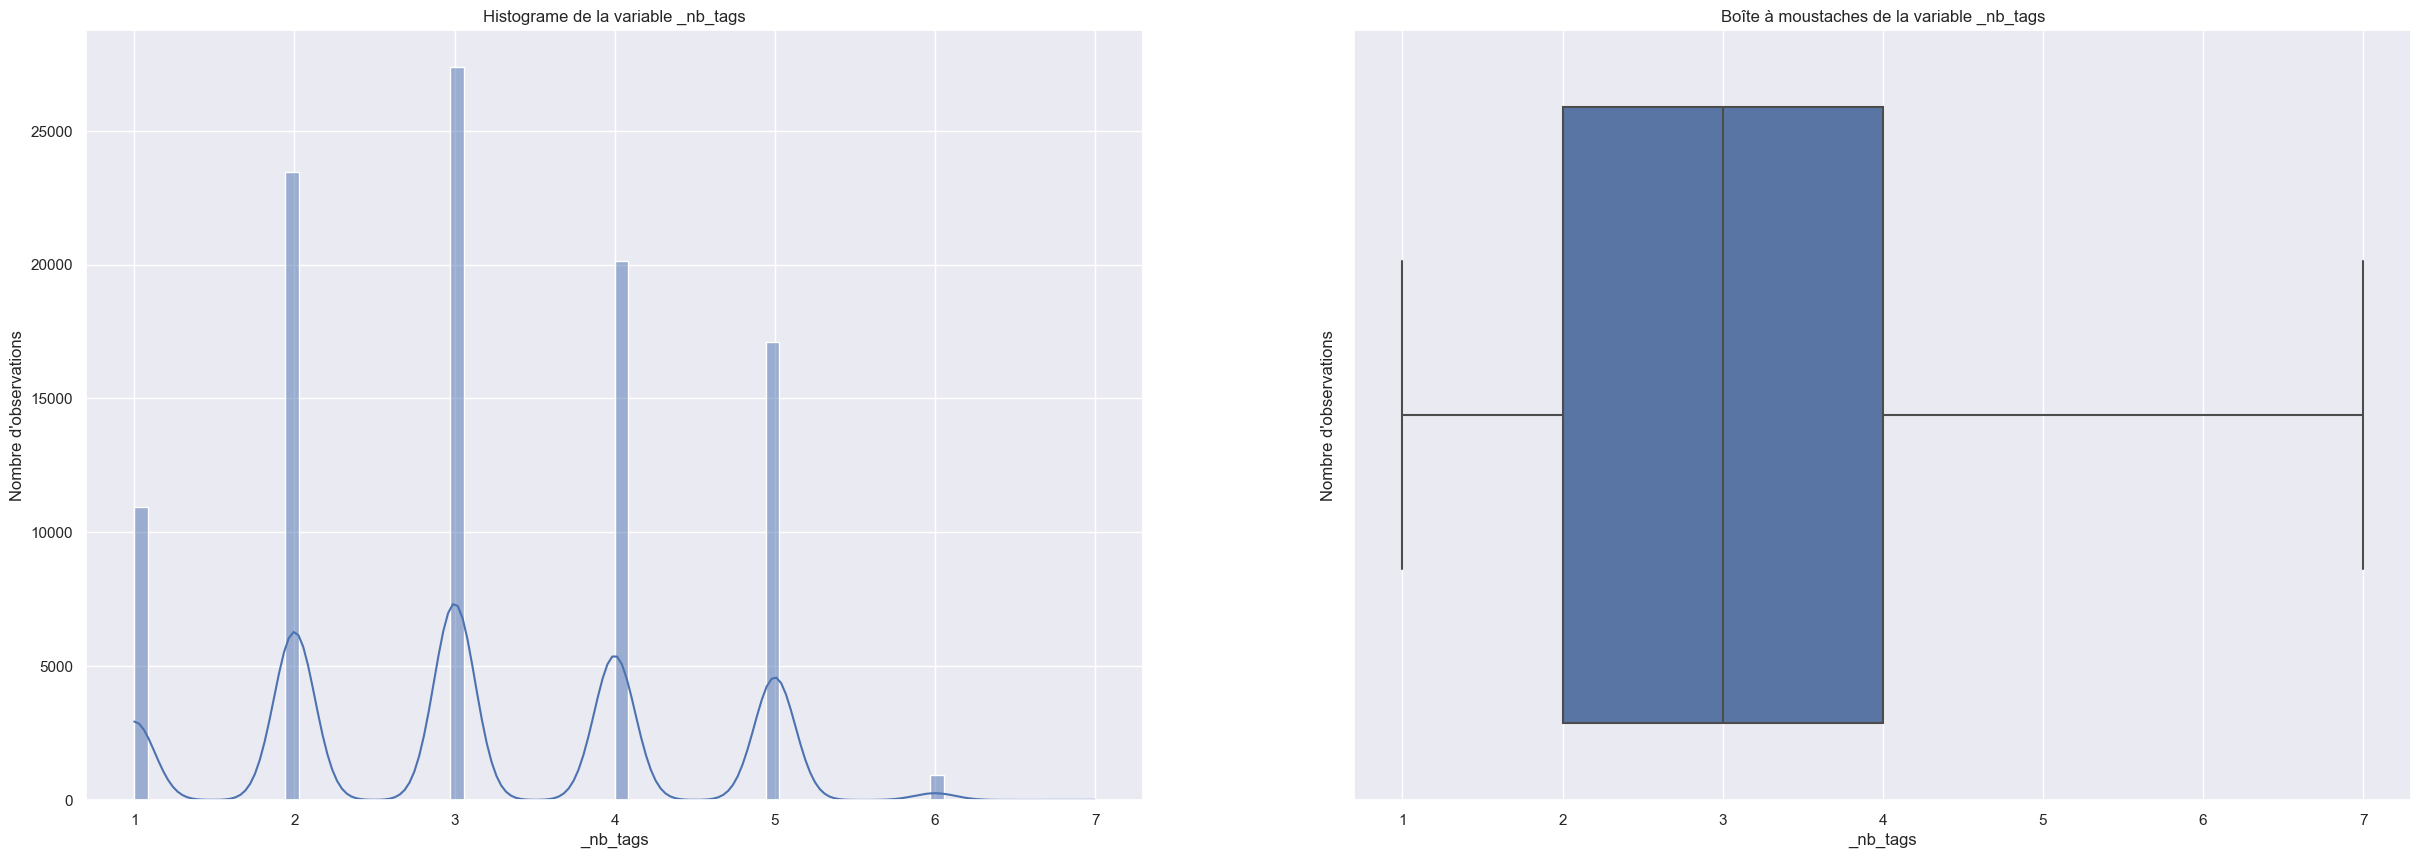

Statistiques de la variable : 
count    99986.000000
mean         3.119117
std          1.276815
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          7.000000
Name: _nb_tags, dtype: float64


In [38]:
affiche_distribution(data=df, col='_nb_tags')

### Title

In [39]:
df.describe(include='object')

,Title,Body,Tags
count,99986,99986,99986
unique,99986,99986,71925
top,can't find button with selenium webdriver,<p>This is really throwing us. I am working on...,<python>
freq,1,1,670


In [40]:
df["_len_Title"] = df.Title.apply(lambda i : len(i))

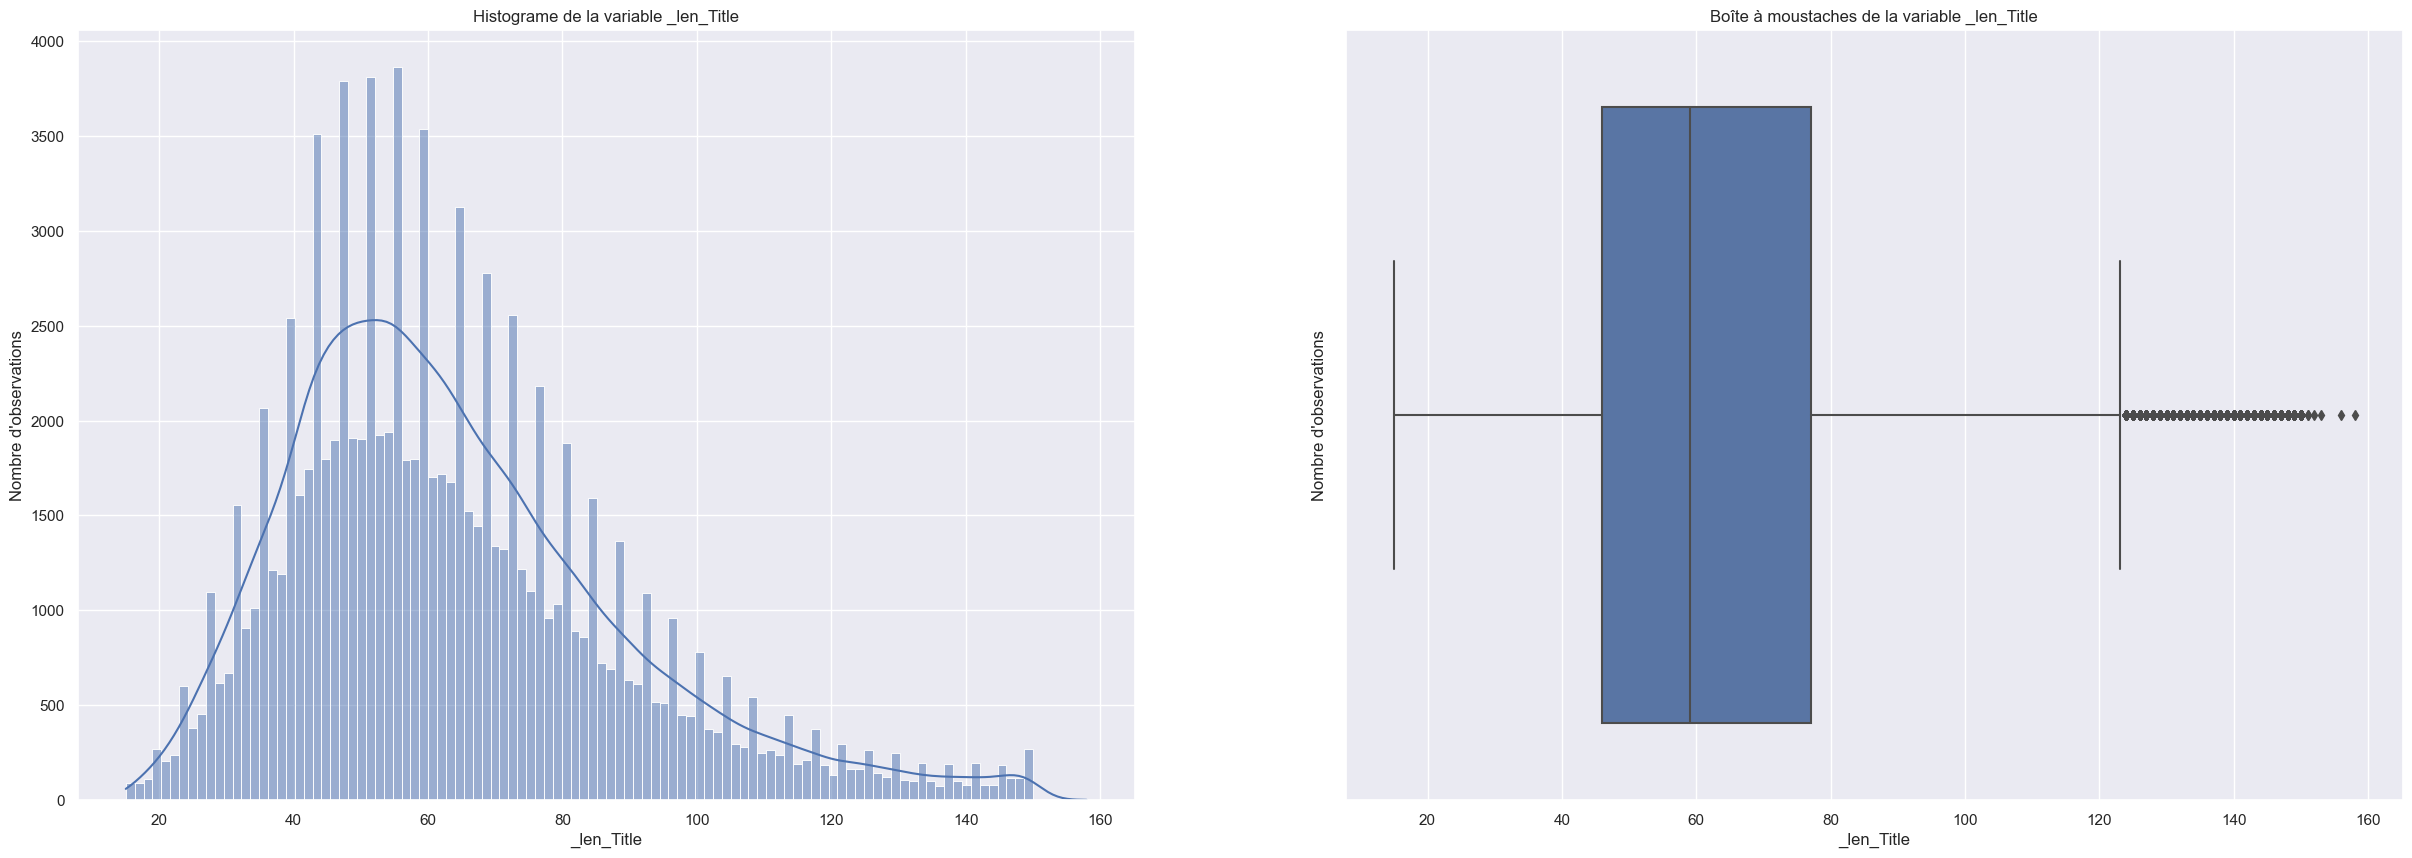

Statistiques de la variable : 
count    99986.000000
mean        63.624067
std         24.724605
min         15.000000
25%         46.000000
50%         59.000000
75%         77.000000
max        158.000000
Name: _len_Title, dtype: float64


In [41]:
affiche_distribution(data=df, col='_len_Title')

### Body

In [42]:
df["_len_Body"] = df.Body.apply(lambda i : len(i))

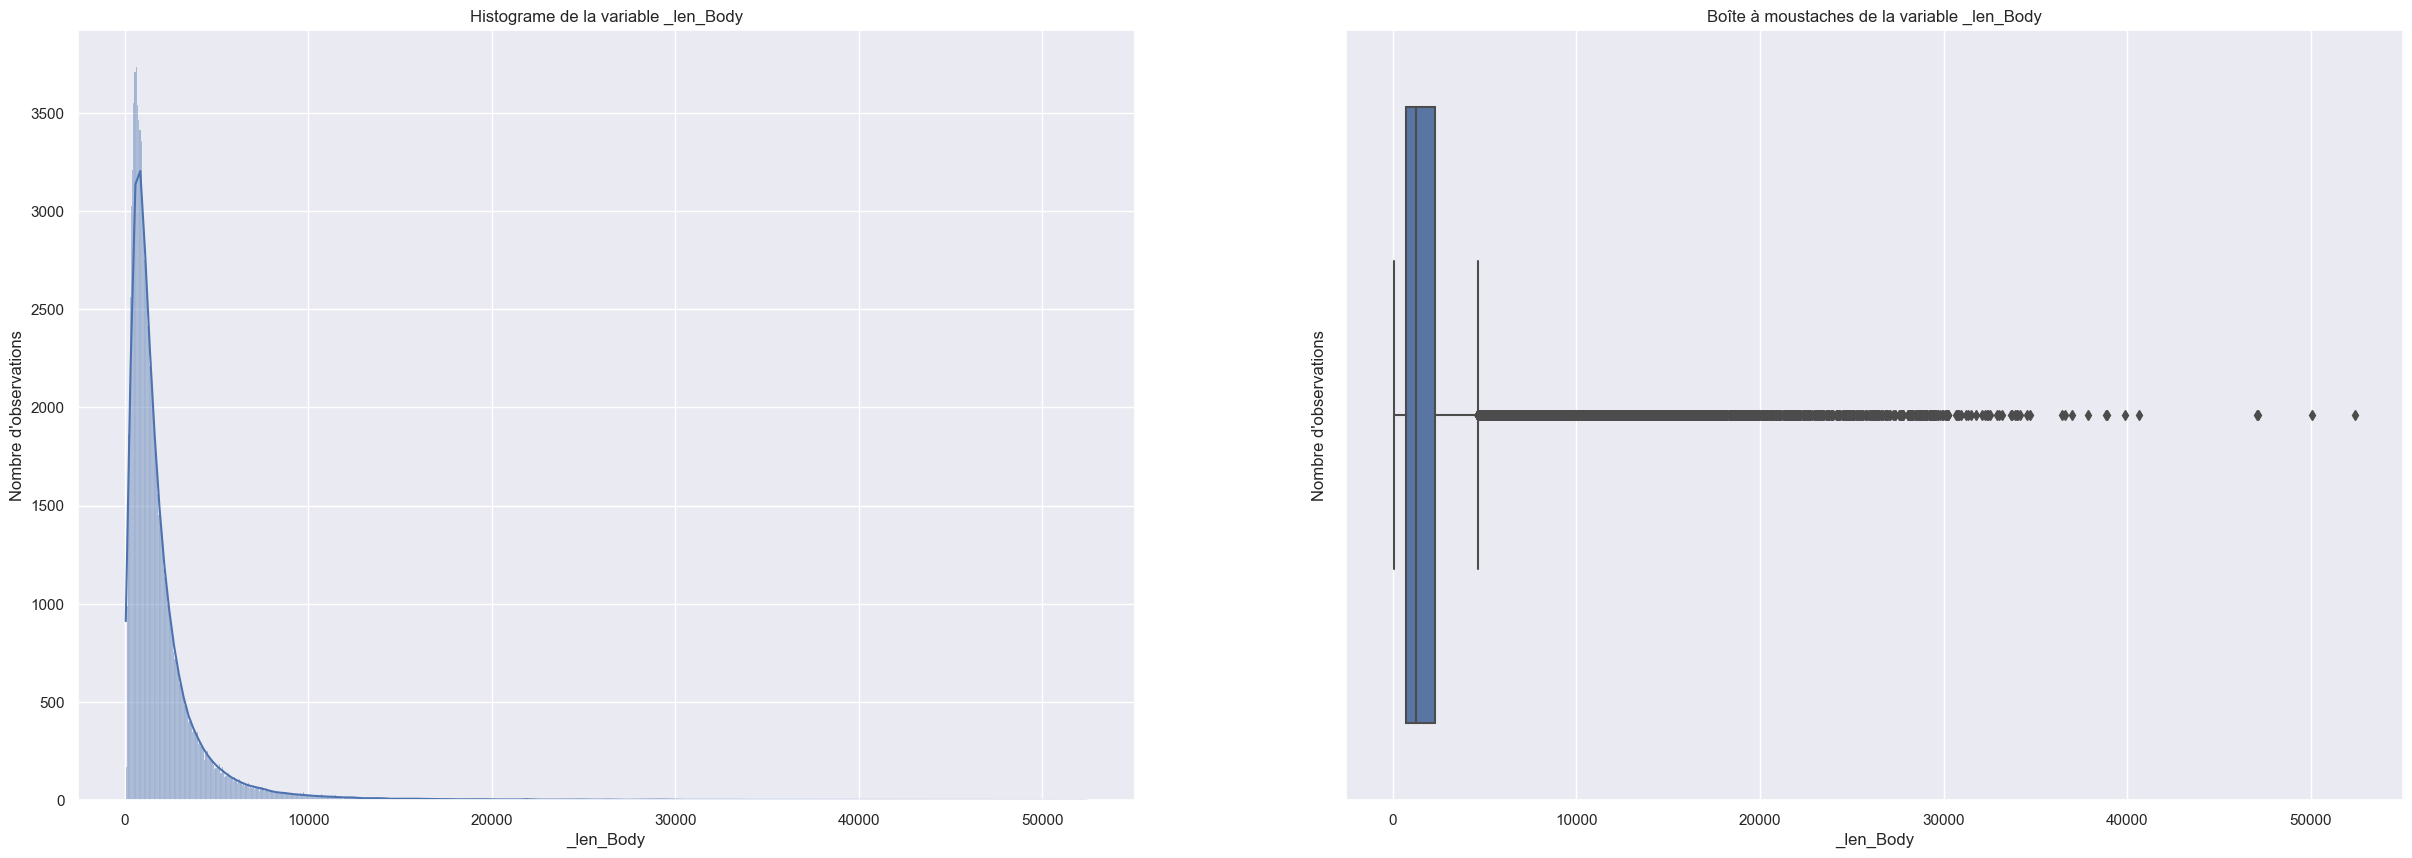

Statistiques de la variable : 
count    99986.000000
mean      1979.024463
std       2519.031564
min         56.000000
25%        708.000000
50%       1263.000000
75%       2282.000000
max      52407.000000
Name: _len_Body, dtype: float64


In [43]:
affiche_distribution(data=df, col='_len_Body')

### Score

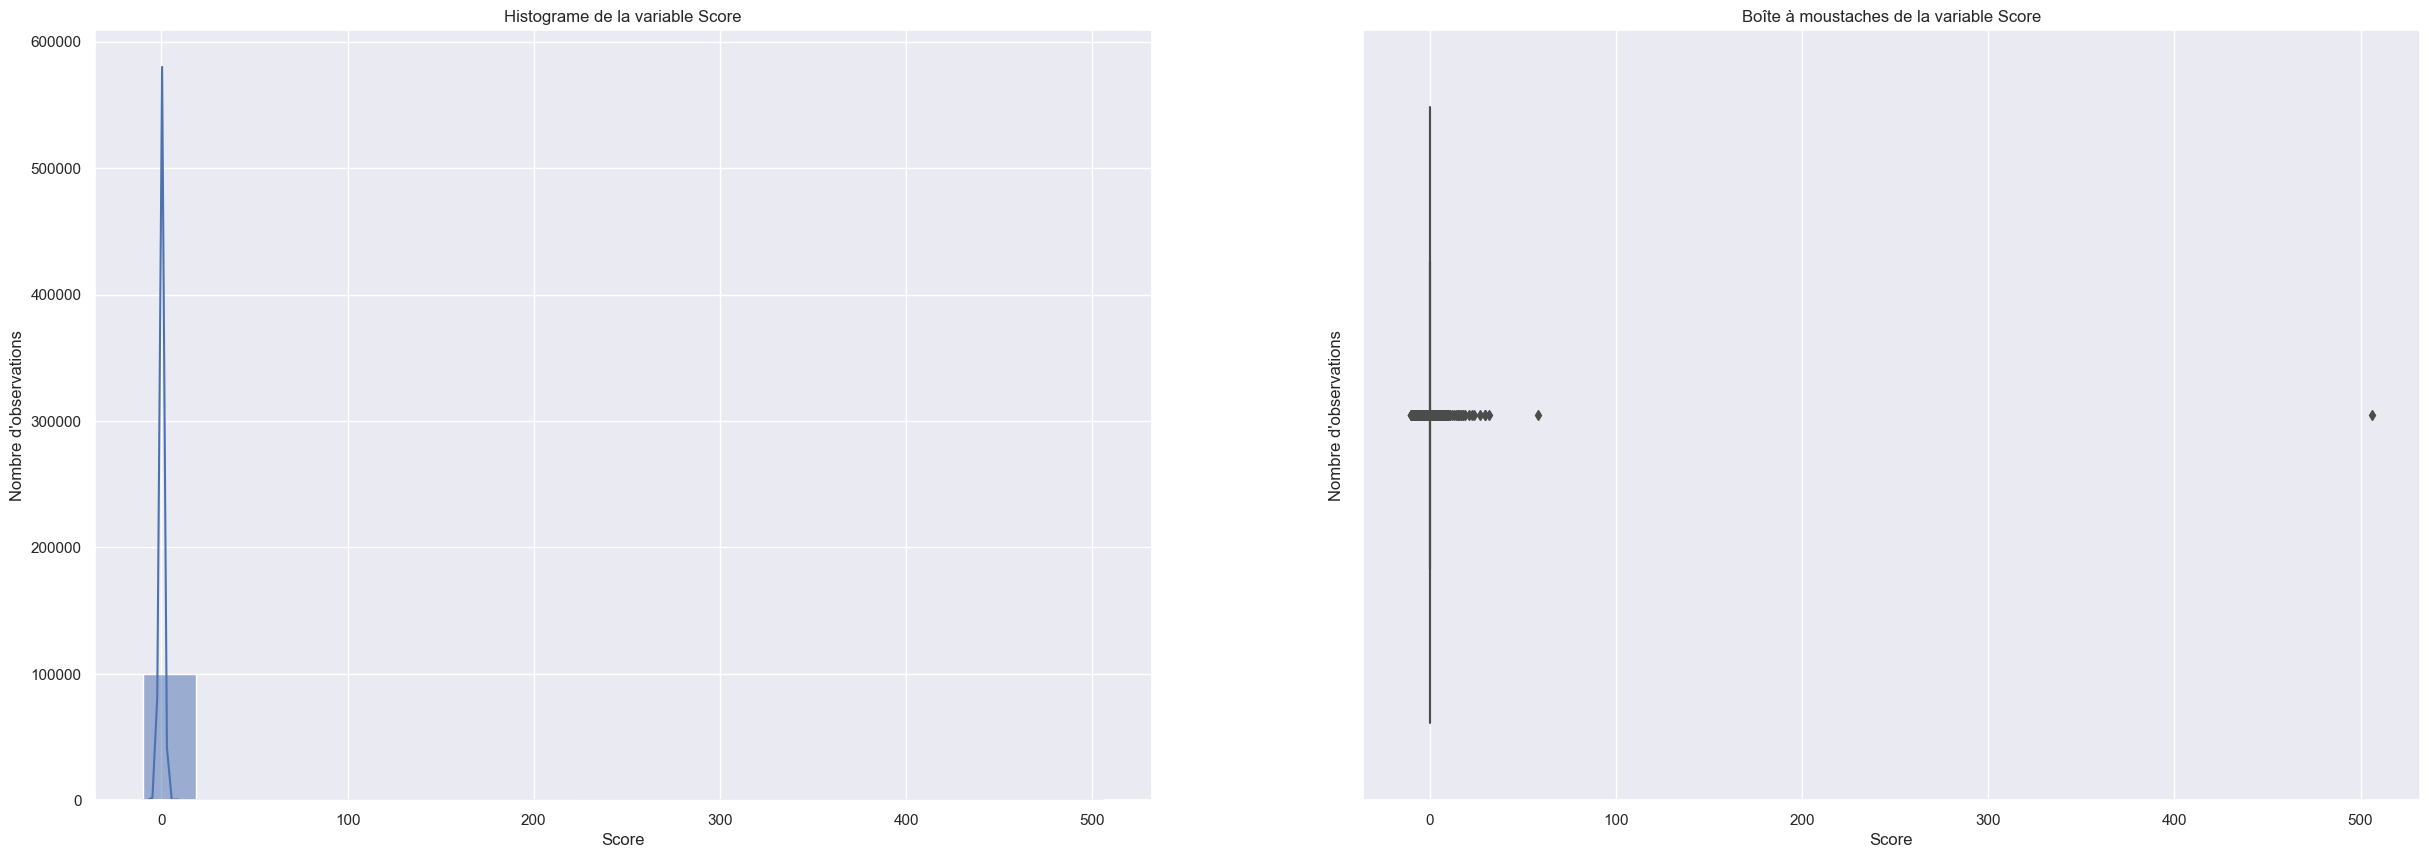

Statistiques de la variable : 
count    99986.000000
mean         0.075161
std          1.863814
min        -10.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        506.000000
Name: Score, dtype: float64


In [44]:
affiche_distribution(data=df, col='Score')

### ViewCount

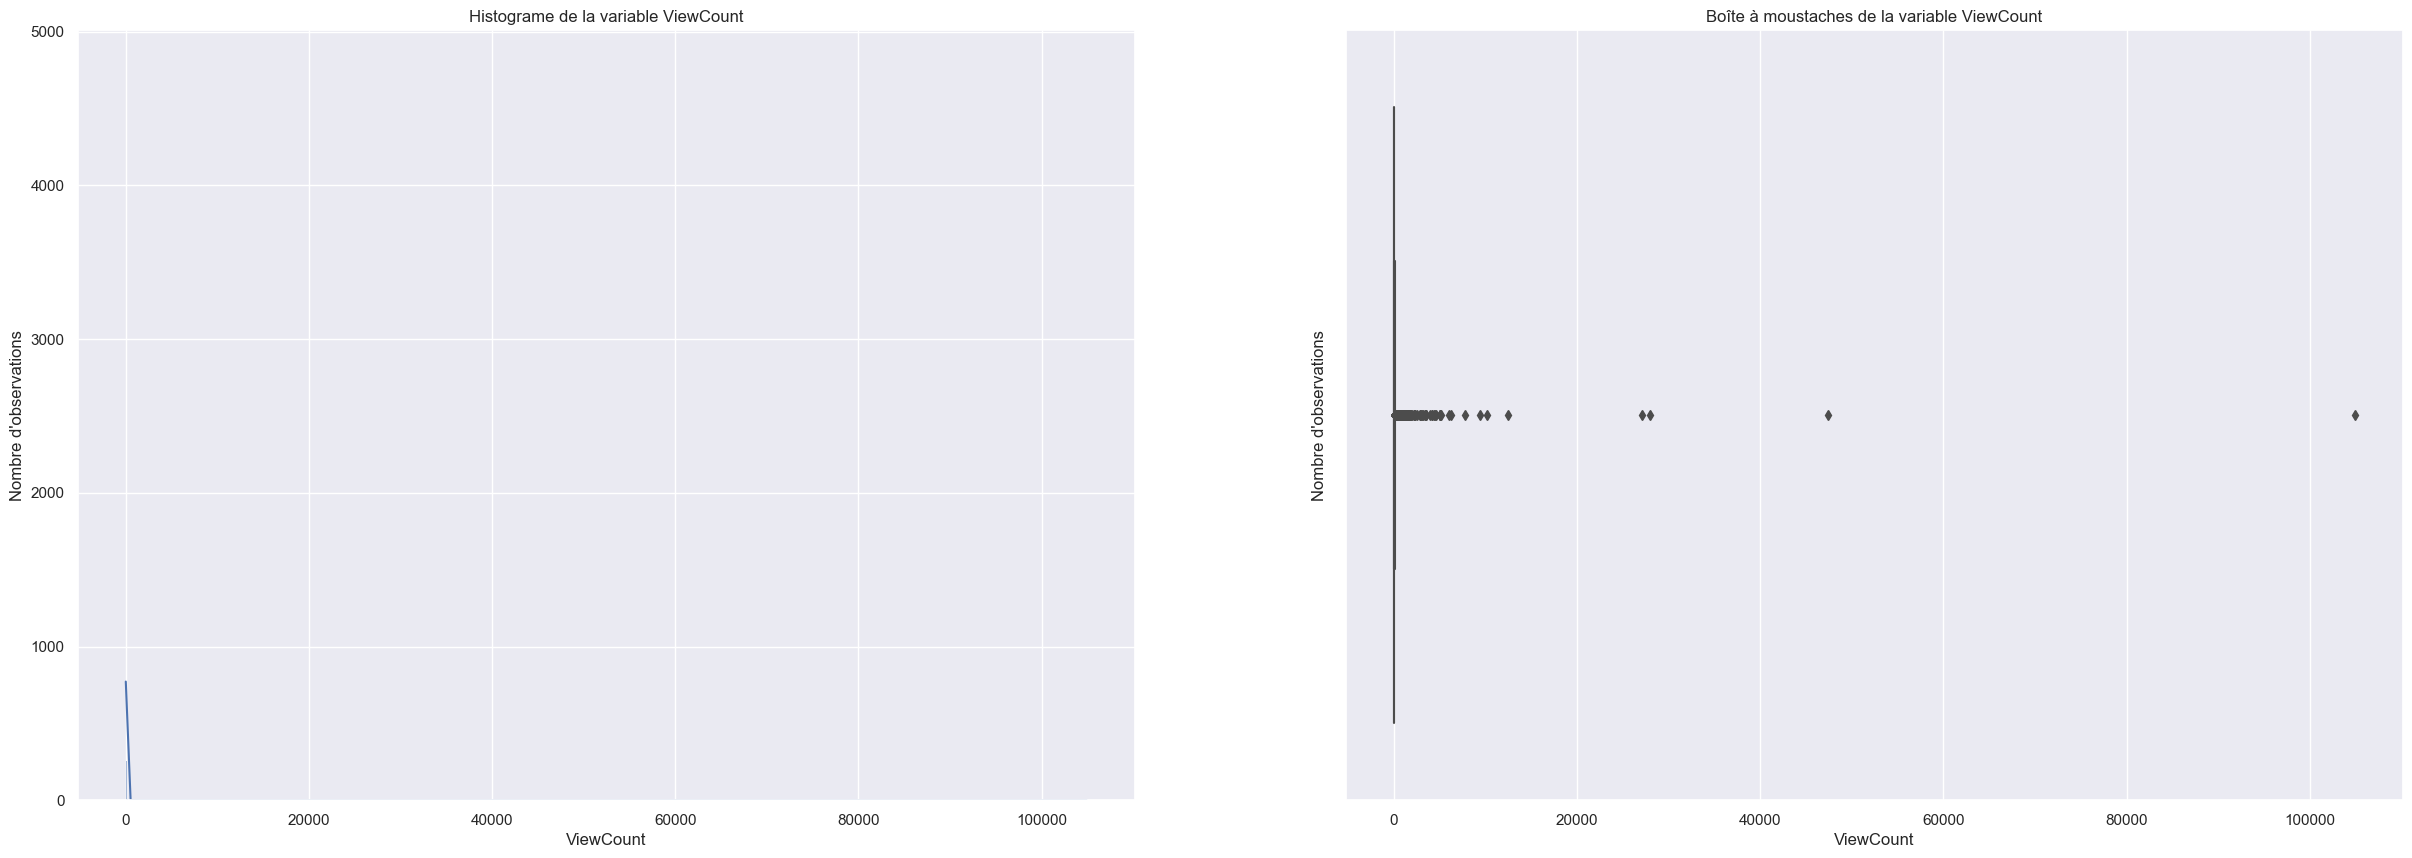

Statistiques de la variable : 
count     99986.000000
mean         44.975977
std         397.118763
min           2.000000
25%          22.000000
50%          33.000000
75%          49.000000
max      104900.000000
Name: ViewCount, dtype: float64


In [45]:
affiche_distribution(data=df, col='ViewCount')

## <a name="C2.4">2.4 Analyse multivariée</a>

In [46]:
corr = df.corr()

<AxesSubplot:>

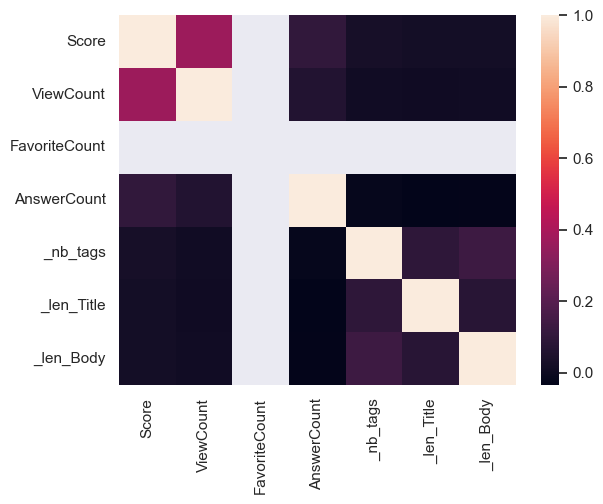

In [47]:
sns.heatmap(corr)

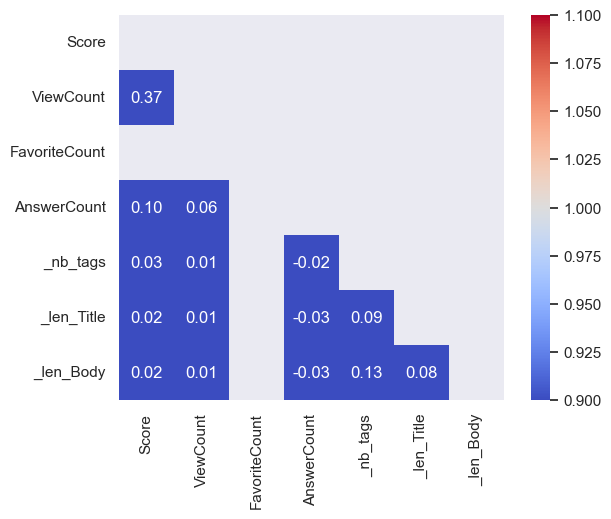

In [48]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(1,1, figsize=(7,5))
ax = sns.heatmap(corr,mask=mask, vmin=1, vmax=1, cmap='coolwarm', annot=True, fmt=('.2f'), square=True)

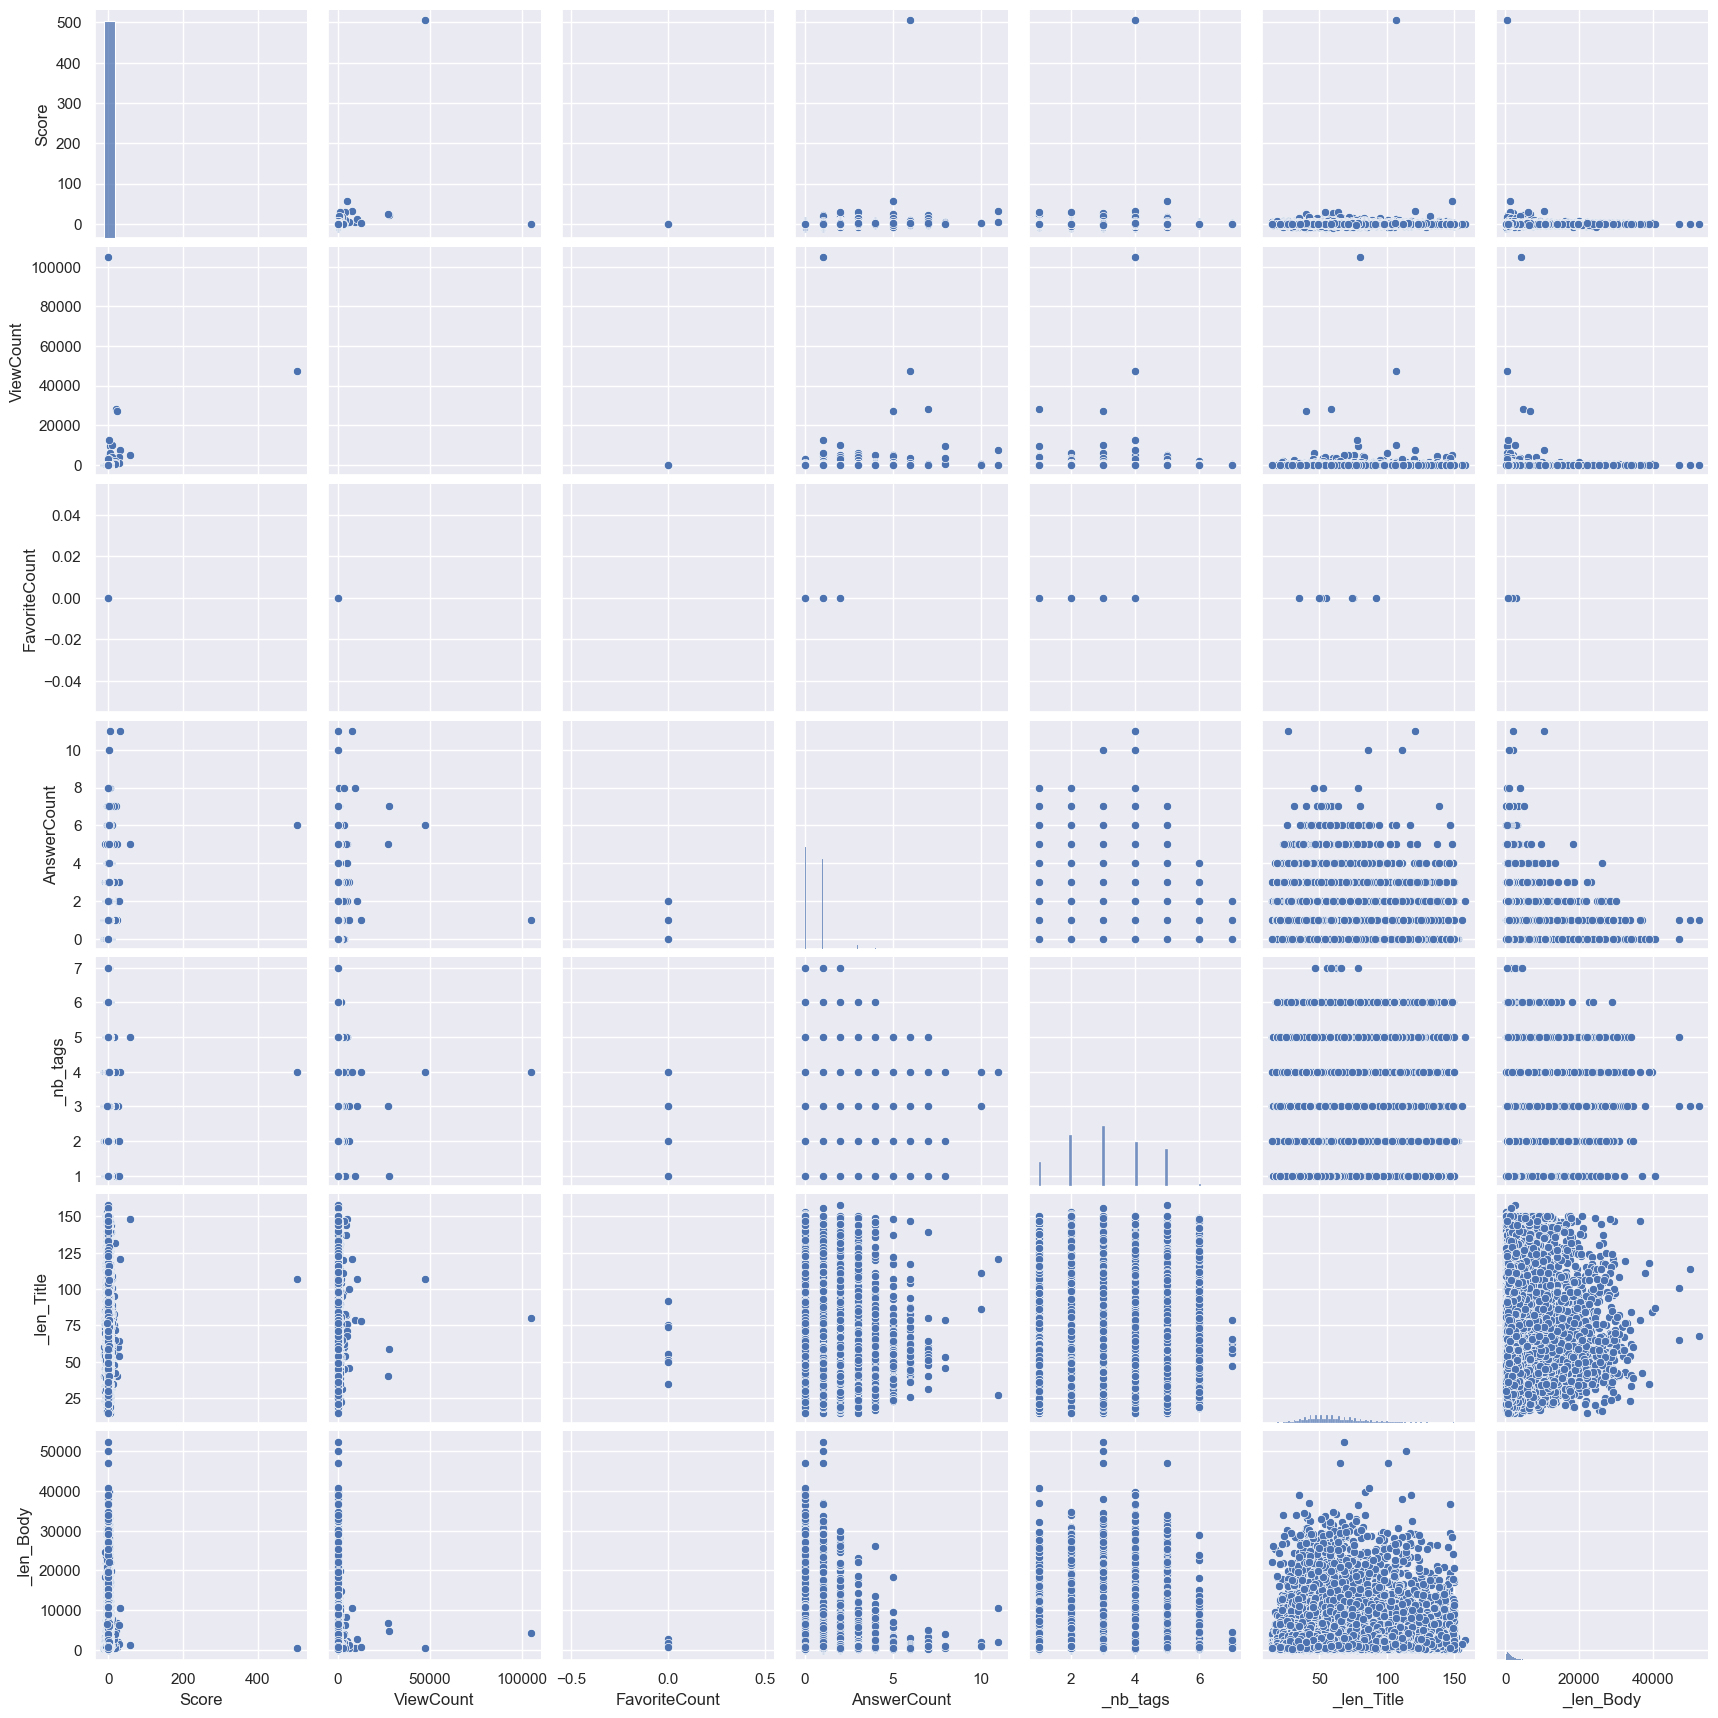

In [49]:
sns.pairplot(df)

# <a name="C3">3 Réduction du jeu de données</a>

## <a name="C3.1">3.1 Nettoyage du code dans le corps du post</a>

In [50]:
# print n random documents
df_samp = df.sample(20)
df_samp

,Title,Body,Tags,Score,ViewCount,FavoriteCount,AnswerCount,_nb_tags,_len_Title,_len_Body
Id,,,,,,,,,,
75768292,Postgres window function not working as expected,<p>I was trying to create postgres query to re...,<sql><postgresql><window-functions>,2,51,NaN,1,3,48,1210
75788223,Deepl api after 3 request go not reply c#,<p>Wtih nugget deepl.net</p>\n<pre><code>publi...,<c#><deepl>,0,23,NaN,0,3,41,829
75816234,JMESPath query on Azure cloud storage returnin...,<p>I can explore on Azure explorer and see the...,<azure><jmespath>,0,20,NaN,0,2,53,721
75855496,How to join by everything except specified col...,<p>I have two datasets that share all columns ...,<r><dplyr>,3,56,NaN,1,2,60,1839
75846340,save image with text to .png,"<p>i have a picture box with image, i add text...",<vb.net><picturebox>,0,27,NaN,2,2,28,1572
75658753,How to implement overlay in VS Code Extension?,<p>I have been developing the VS Code extensio...,<typescript><visual-studio-code><vscode-extens...,0,64,NaN,1,3,46,878
75775480,Trying to select only the smallest value in a ...,<p>Not sure if theres a way to make individual...,<python><for-loop><tkinter><tkinter-entry>,0,23,NaN,0,4,96,726
75720809,React sends Form input to backend everytime i ...,<blockquote>\n<p>I have this function that sen...,<reactjs><post><input><axios>,0,28,NaN,2,4,74,2489
75752384,docker-compose postgres container connects to ...,<p>I have a project with three containers: pyt...,<python><django><postgresql><docker>,0,35,NaN,0,4,96,4021


In [51]:
for idx, ser in df_samp.iterrows():
    print (f"Tags : {ser['Tags']}")
    print (f"Titre : {ser['Title']}")
    print (f"Texte : {ser['Body']}\n")    

Tags : <sql><postgresql><window-functions>
Titre : Postgres window function not working as expected
Texte : <p>I was trying to create postgres query to return open and close price of market bars for different intervals (LAST 7 DAYS, LAST MONTH, LAST 6 MONTHS, etc ...). It seemed easy to do it in simple query but it is not easy as I thought (or I do not know how to do it).</p>
<p>To simplify things, I created 2 examples in dbfiddle which I will shortly explain:</p>
<p><a href="https://dbfiddle.uk/4iPeLzM6" rel="nofollow noreferrer">https://dbfiddle.uk/4iPeLzM6</a>  :  inserted several bars and in query created 2 intervals, one starting from '2023-03-12' and another one starting from '2023-03-15'. Joining bars with bar_intervals and result seems logical, P1 has all bars and P2 has bars starting from '2023-03-15'</p>
<p><a href="https://dbfiddle.uk/NyoIG1JC" rel="nofollow noreferrer">https://dbfiddle.uk/NyoIG1JC</a>  : tried to get open price and close price for P1 and P2 intervals, and I

In [52]:
# Le corps du post est nettoyé du code qu'il pourrait contenir
def isoler_code(texte):
    texte_code = texte[texte.find("<pre><code>") + len ("<pre><code>"):texte.find("</code></pre>")]
    return texte_code

In [53]:
def renseigne_code(row):
    code_text = ""
    body_text = row['Body']
    while (body_text.find("<pre><code>") != -1):    
        pgm_text = isoler_code(body_text)
        code_text = "".join([code_text, pgm_text])
        body_text = body_text.replace("<pre><code>","",1)
        body_text = body_text.replace(pgm_text,"")
        body_text = body_text.replace("</code></pre>","",1)
    row['Body'] = body_text
    row["Code"] = code_text
    return row

In [54]:
pd.set_option('mode.chained_assignment',None)
df = df.apply(renseigne_code, axis=1)
%time

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 8.82 µs


In [55]:
#from whats_that_code.election import guess_language_all_methods
#code = "df = df.apply(renseigne_code, axis=1)"
#result = guess_language_all_methods(code)
#result

In [56]:
#from whats_that_code.election import guess_language_all_methods
#def cherche_langage(text):
##    guess = Guess()
#    langue = ""
#    try :
#        if len(text) != 0:
#            langue = guess_language_all_methods(text)
##            langue = guess(text[0][0][0:-1])
#    except TypeError:
#        print ("Langue inconnue")
#    return langue

In [57]:
# Le langage de programmation est conservé pour un éventuel traitement ultérieur
#df['Langue'] = df['Code'].apply(lambda txt : cherche_langage(txt))
#df['Langue']

In [58]:
df_samp = df.loc[df.Title == "Uploading Large file over httpPost throws unknown error in Angular 14"]
for idx, ser in df_samp.iterrows():
    print (f"Tags : {ser['Tags']}")
    print (f"Titre : {ser['Title']}")
    print (f"Code : {ser['Code']}\n")  

Tags : <javascript><angular><asp.net-core><file-upload><http-post>
Titre : Uploading Large file over httpPost throws unknown error in Angular 14
Code : progress: number;
message: string;
@Output() public onUploadFinished = new EventEmitter();

constructor(private http: HttpClient) { }

uploadFile = (files: any) =&gt; {
 if (files.length === 0) {
   return;
 }
 let fileToUpload = &lt;File&gt;files[0];
  const formData = new FormData();
formData.append('file', fileToUpload, fileToUpload.name);

 this.http.post('https://localhost:44468/api/upload', formData, { reportProgress: true, 
  observe: 'events' })
    .subscribe({
     next: (event: any) =&gt; {
       if (event.type === HttpEventType.UploadProgress)
         this.progress = Math.round(100 * event.loaded / event.total);
      else if (event.type === HttpEventType.Response) {
         this.message = 'Upload success.';
         this.onUploadFinished.emit(event.body);
       }
     },
     error: (err: HttpErrorResponse) =&gt; consol

In [59]:
cols = ["Title", "Body", "Tags"]
df=df[cols]

## <a name="C3.2">3.2 Réduction des Posts</a>

### <a name="C3.2.1">3.2.1 Initialisation</a>

#### Fonctions de traitement des textes

In [60]:
def tokens_display_info(tokens):
    print (f"Nb tokens {len(tokens)}, Nb tokens uniques : {len(set(tokens))}")

In [61]:
def process_text(doc, 
                   rejoin=False,
                   lemm_or_stemm ="stem",
                  list_rare_words=None,
                  min_len_word=3,
                  force_is_alpha=True):
    
    """basic function of text processing 
    positional arguments :
    --------------------
    doc : str : the document to process
    
    opt args :
    --------
    rejoin : bool : if True return a string else return the list of tokens
    lemm_or_stemm : str : apply lemmatize or stemmatize
    list_rare_words : list : a list of rare words to exclude
    min_len_word : int : the miminmum length of words to not exclude
    force_is_alpha : int : if 1, exclude all tokens with a numeric character
    
    return :
    -------
    a string (if rejoin is True) or a list of tokens
    
    """
    
    # liste_unique_words
    if not list_rare_words:
        list_rare_words = []
    
    # lower 
    doc = doc.lower().strip()
    
    # tokenize
    tokenizer = RegexpTokenizer(r"\w+")
    raw_tokens_list = tokenizer.tokenize(doc)
    
    # stop words
    cleaned_tokens_list = [w for w in raw_tokens_list if w not in stop_words]
    
    # no rare tokens
    non_rare_tokens = [w for w in cleaned_tokens_list if w not in list_rare_words]
    
    # no more len words
    more_than_N = [w for w in non_rare_tokens if len(w) >= min_len_word]
    
    # if only alpha chars
    if force_is_alpha :
        alpha_tokens = [w for w in more_than_N if w.isalpha()]
    else :
        alpha_tokens = more_than_N 
    
    # lemm or stemm
    if lemm_or_stemm == "lemm" :
        trans = WordNetLemmatizer()
        trans_text = [trans.lemmatize(i) for i in alpha_tokens]
    else :
        trans = PorterStemmer()
        trans_text = [trans.stem(i) for i in alpha_tokens]
    
    if rejoin : 
        return " ".join(trans_text)
    return trans_text

#### Initialisation des Stops-words

In [62]:
stop_words = stopwords.words('english')
print (stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [63]:
pd.Series(words.words()).sample(10)

191646           subbias
101622       keratonyxis
83625        heliostatic
180066        shelterage
230432            warbly
49182             debord
78360            gnomide
76881     Gerrhosauridae
24760         bootlessly
223775       unswathable
dtype: object

#### Initialisation des mots en anglais

In [64]:
len(set(words.words()))

235892

In [65]:
eng_words = [i.lower() for i in words.words()]
eng_words[:10]

['a',
 'a',
 'aa',
 'aal',
 'aalii',
 'aam',
 'aani',
 'aardvark',
 'aardwolf',
 'aaron']

In [66]:
lm = WordNetLemmatizer()
eng_words_lem = [lm.lemmatize(i) for i in eng_words]
tokens_display_info(eng_words_lem)

Nb tokens 236736, Nb tokens uniques : 233450


### <a name="C3.2.2">3.2.2 Traitement de l'ensemble du corpus</a>

In [67]:
corpus_Title = "".join(df.Title.values)
corpus_Body = "".join(df.Body.values)

In [68]:
raw_corpus = corpus_Title + corpus_Body

In [69]:
corpus = process_text(raw_corpus, rejoin=False)
pd.Series(corpus).sample(10)

380378             format
4629339              code
5153845    searchincolumn
1658059              work
5343321             defin
6617023             nextj
1571879               div
509923            without
4220810            player
3111127               rel
dtype: object

In [70]:
tmp = pd.Series(corpus).value_counts()
res = []
for i in range(1,50):
    liste_n_words = tmp[tmp<=i]
    res.append(len(liste_n_words))

In [71]:
dfr = pd.DataFrame(res, columns=["Nb_words"])

In [72]:
len(corpus)

8576913

<AxesSubplot:>

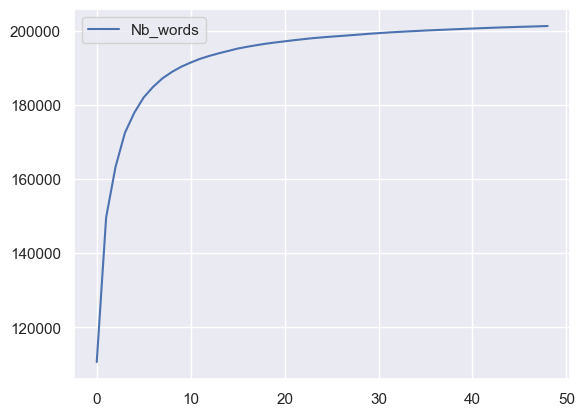

In [73]:
dfr.plot(y="Nb_words")

In [74]:
print ("Proportion des mots apparaissant moins de 8 fois dans le corpus : " + 
       str(round(len(tmp[tmp[tmp<=8]])/len(corpus)*100,2)) + "%")

Proportion des mots apparaissant moins de 8 fois dans le corpus : 2.18%


In [75]:
list_rare_words = tmp[tmp<=8]

In [76]:
# Liste des mots courants propres au domaine de Stackoverflow 

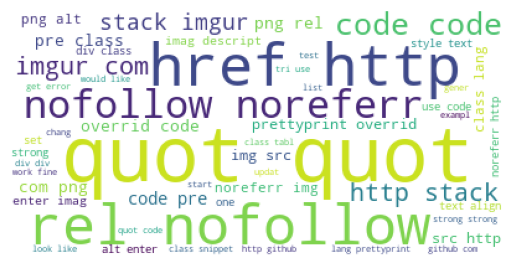

In [77]:
wordcloud = WordCloud(background_color="white",
                     stopwords=[],
                     max_words=50).generate(" ".join(corpus))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### <a name="C3.2.3">3.2.3 Nettoyage des textes et des Tags</a>

In [78]:
# Tokenizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').\
                             replace('#', ' ').replace('<p>', ' ').replace('>', ' ').replace('<', ' ')
    # Remove ponctuation (except # and ++ for c# and c++)
    sentence_clean1 = re.sub('[^\\w\\s#\\s++]', ' ', sentence_clean)

    # Remove numbers
    sentence_clean2 = re.sub(r'\w*\d+\w*', ' ', sentence_clean1)

    # Remove extra spaces
    sentence_clean = re.sub('\s+', ' ', sentence_clean2)
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']
stop_w.extend(['code', 'quot', 'use', 'http', 'com', 'error', 'work', 'want', 'one', 'would', 'need', 
                   'help', 'also', 'exampl', 'could', 'thing', 'well', 'dear', 'p'])

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
#    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
                                      and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

df['title_bow'] = df['Title'].apply(lambda x : transform_bow_fct(x))
df['body_bow'] = df['Body'].apply(lambda x : transform_bow_fct(x))
df['tag_bow'] = df['Tags'].apply(lambda x : transform_bow_fct(x))
#df['tag_bow'] = df['tag_bow'].apply(lambda raw : list(set(raw)))
df['body_bow_lem'] = df['Body'].apply(lambda x : transform_bow_lem_fct(x))
df['body_dl'] = df['Body'].apply(lambda x : transform_dl_fct(x))
df.shape

(99986, 8)

## <a name="C3.3">3.3 Analyse textuelle</a>

### <a name="C3.3.1">3.3.1 Représentation visuelle</a>

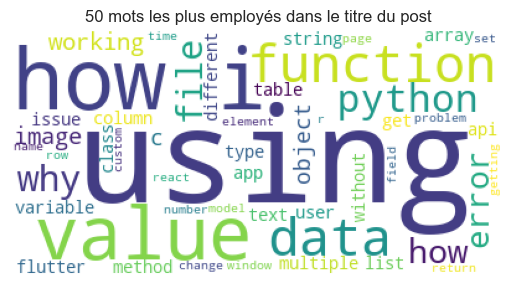

In [83]:
Title_tokens = [token for token_list in df.title_bow for token in token_list.split(" ")]
wordcloud = WordCloud(background_color="white",
                     stopwords=[],
                     max_words=50).generate(" ".join(Title_tokens))
plt.imshow(wordcloud)
plt.title("50 mots les plus employés dans le titre du post")
plt.axis("off")
plt.show()

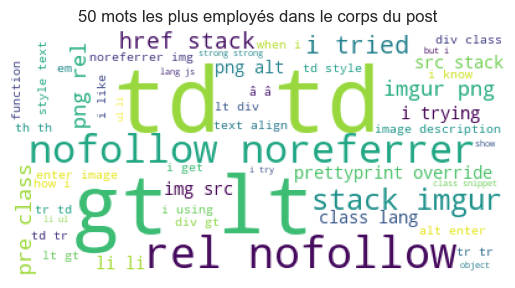

In [84]:
Body_tokens = [token for token_list in df.body_bow for token in token_list.split(" ")]
wordcloud = WordCloud(background_color="white",
                     stopwords=[],
                     max_words=50).generate(" ".join(Body_tokens))
plt.imshow(wordcloud)
plt.title("50 mots les plus employés dans le corps du post")
plt.axis("off")
plt.show()

### <a name="C3.3.2">3.3.2 Analyse de la distribution des tokens</a>

In [85]:
df

,Title,Body,Tags,title_bow,body_bow,tag_bow,body_bow_lem,body_dl
Id,,,,,,,,
75598427,can't find button with selenium webdriver,<p>This is really throwing us. I am working on...,<python><html><selenium-webdriver><automation>...,find button selenium webdriver,this really throwing us i working indeed appli...,python html selenium webdriver automation bots,this really throwing u i working indeed applic...,this is really throwing us i am working on an ...
75598430,How to generate all possible melody strings fo...,"<p>I have this question in the Math site, to f...",<algorithm>,how generate possible melody strings melody ge...,i question math site figure calculate number c...,algorithm,i question math site figure calculate number c...,i have this question in the math site to figur...
75598432,Create access policy for NiFi using REST API,<p>I am trying to set an access policy to a Ni...,<python><rest><apache-nifi>,create access policy nifi using rest api,i trying set access policy nifi instance using...,python rest apache nifi,i trying set access policy nifi instance using...,i am trying to set an access policy to a nifi ...
75598434,"node-gyp ld: warning: ignoring file <file>, bu...",<p>I am getting this error in Github Actions r...,<node-gyp>,node gyp ld warning ignoring file file buildin...,i getting github actions running macos i like ...,node gyp,i getting github action running macos i like f...,i am getting this error in github actions runn...
75598435,Update a table based on the existence of a row...,"<p>This is a bit confusing to explain, but bas...",<mysql><sql>,update table based existence row subtable,this bit confusing explain basically i got par...,mysql sql,this bit confusing explain basically i got par...,this is a bit confusing to explain but basical...
...,...,...,...,...,...,...,...,...
75869704,how to filter efficiently for many terms,"<p>First, I *do *have a solution to this, than...",<r><dataframe><filter><data-wrangling>,filter efficiently many terms,first i solution thanks colleague rosie hartma...,r dataframe filter data wrangling,first i solution thanks colleague rosie hartma...,first i do have a solution to this thanks to m...
75872804,Related to Databricks policies,<p>need to write powershell script for Databri...,<powershell>,related databricks policies,write powershell script databricks policies ho...,powershell,write powershell script databricks policy how ...,need to write powershell script for databricks...
75868369,Creating a table with two colon delimited strings,<p>I am currently trying to make a PL/SQL func...,<plsql><oracle-apex>,creating table two colon delimited strings,i currently trying make pl sql function takes ...,plsql oracle apex,i currently trying make pl sql function take t...,i am currently trying to make a pl sql functio...


In [86]:
df['nb_tokens_title'] = ""
df['nb_tokens_body'] = ""
df['nb_tags'] = ""
df['nb_tokens_shared'] = ""

for i in range(len(df)):
    df.iloc[i,8] = len(df.iloc[i,3].split(" "))
    df.iloc[i,9] = len(df.iloc[i,4].split(" "))
    df.iloc[i,10] = len(df.iloc[i,5].split(" "))

In [87]:
df['nb_tokens_shared'] = [len(set(a) & set(b)) for a, b in zip(df.title_bow, df.body_bow)]

In [88]:
df.head(2)

,Title,Body,Tags,title_bow,body_bow,tag_bow,body_bow_lem,body_dl,nb_tokens_title,nb_tokens_body,nb_tags,nb_tokens_shared
Id,,,,,,,,,,,,
75598427,can't find button with selenium webdriver,<p>This is really throwing us. I am working on...,<python><html><selenium-webdriver><automation>...,find button selenium webdriver,this really throwing us i working indeed appli...,python html selenium webdriver automation bots,this really throwing u i working indeed applic...,this is really throwing us i am working on an ...,4,66,6,15
75598430,How to generate all possible melody strings fo...,"<p>I have this question in the Math site, to f...",<algorithm>,how generate possible melody strings melody ge...,i question math site figure calculate number c...,algorithm,i question math site figure calculate number c...,i have this question in the math site to figur...,12,66,1,21


In [89]:
df.iloc[0,:]

Title                       can't find button with selenium webdriver
Body                <p>This is really throwing us. I am working on...
Tags                <python><html><selenium-webdriver><automation>...
title_bow                              find button selenium webdriver
body_bow            this really throwing us i working indeed appli...
tag_bow                python html selenium webdriver automation bots
body_bow_lem        this really throwing u i working indeed applic...
body_dl             this is really throwing us i am working on an ...
nb_tokens_title                                                     4
nb_tokens_body                                                     66
nb_tags                                                             6
nb_tokens_shared                                                   15
Name: 75598427, dtype: object

In [90]:
df['nb_tags_shared_Title'] = 0
df['nb_tags_shared_Body'] = 0
Tag_tokens = []
for i in range(len(df)):
    nb_tags_shared_Title = 0
    nb_tags_shared_Body = 0
    for word in df.iloc[i,5].split(" "):
        Tag_tokens.append(word)
        if df.iloc[i,3].count(word) > 0 :
            nb_tags_shared_Title = nb_tags_shared_Title + 1
        if df.iloc[i,4].count(word) > 0 :
            nb_tags_shared_Body = nb_tags_shared_Body + 1
    df.iloc[i,12] = nb_tags_shared_Title
    df.iloc[i,13] = nb_tags_shared_Body
    

In [91]:
df.iloc[0,:]

Title                           can't find button with selenium webdriver
Body                    <p>This is really throwing us. I am working on...
Tags                    <python><html><selenium-webdriver><automation>...
title_bow                                  find button selenium webdriver
body_bow                this really throwing us i working indeed appli...
tag_bow                    python html selenium webdriver automation bots
body_bow_lem            this really throwing u i working indeed applic...
body_dl                 this is really throwing us i am working on an ...
nb_tokens_title                                                         4
nb_tokens_body                                                         66
nb_tags                                                                 6
nb_tokens_shared                                                       15
nb_tags_shared_Title                                                    2
nb_tags_shared_Body                   

In [92]:
print (f"Nombre total de tokens dans le titre : {df.nb_tokens_title.sum()}")           
#        avec {df.nb_tokens_shared.sum()/df.nb_tokens_title.sum()*100:.1f}% de tokens communs")
print (f"Nombre total de tokens dans le corps du post : {df.nb_tokens_body.sum():,} \
        avec {df.nb_tokens_shared.sum()/df.nb_tokens_body.sum()*100:.1f}% de tokens communs")
print (f"Nombre total de tokens communs aux 2 : {df.nb_tokens_shared.sum():,}")


Nombre total de tokens dans le titre : 714569
Nombre total de tokens dans le corps du post : 8,614,151         avec 20.3% de tokens communs
Nombre total de tokens communs aux 2 : 1,746,828


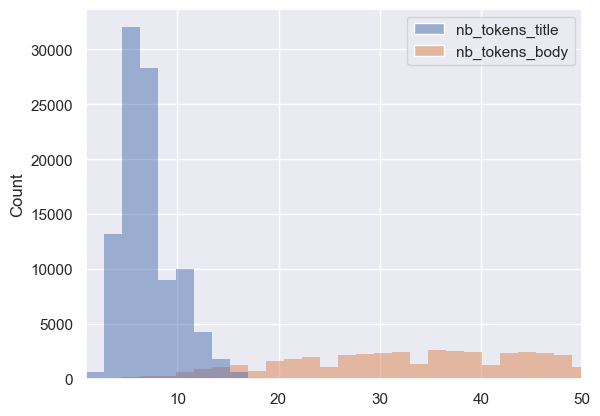

In [93]:
g = sns.histplot(data=df[['nb_tokens_title', 'nb_tokens_body']])
g.set_xlim(1, 50)
plt.show()

In [94]:
print (f"Nombre total de token dans les tags  : {df.nb_tags.sum():,}")
print (f"Nombre total de tags dans les Titres : {df.nb_tags_shared_Title.sum():,} \
      soit {df.nb_tags_shared_Title.sum()/df.nb_tokens_title.sum()*100:.1f}% ")
print (f"Nombre total de tags dans le Corps   : {df.nb_tags_shared_Body.sum():,} \
       soit {df.nb_tags_shared_Body.sum()/df.nb_tokens_body.sum()*100:.1f}% ")

Nombre total de token dans les tags  : 405,033
Nombre total de tags dans les Titres : 176,575       soit 24.7% 
Nombre total de tags dans le Corps   : 226,505        soit 2.6% 


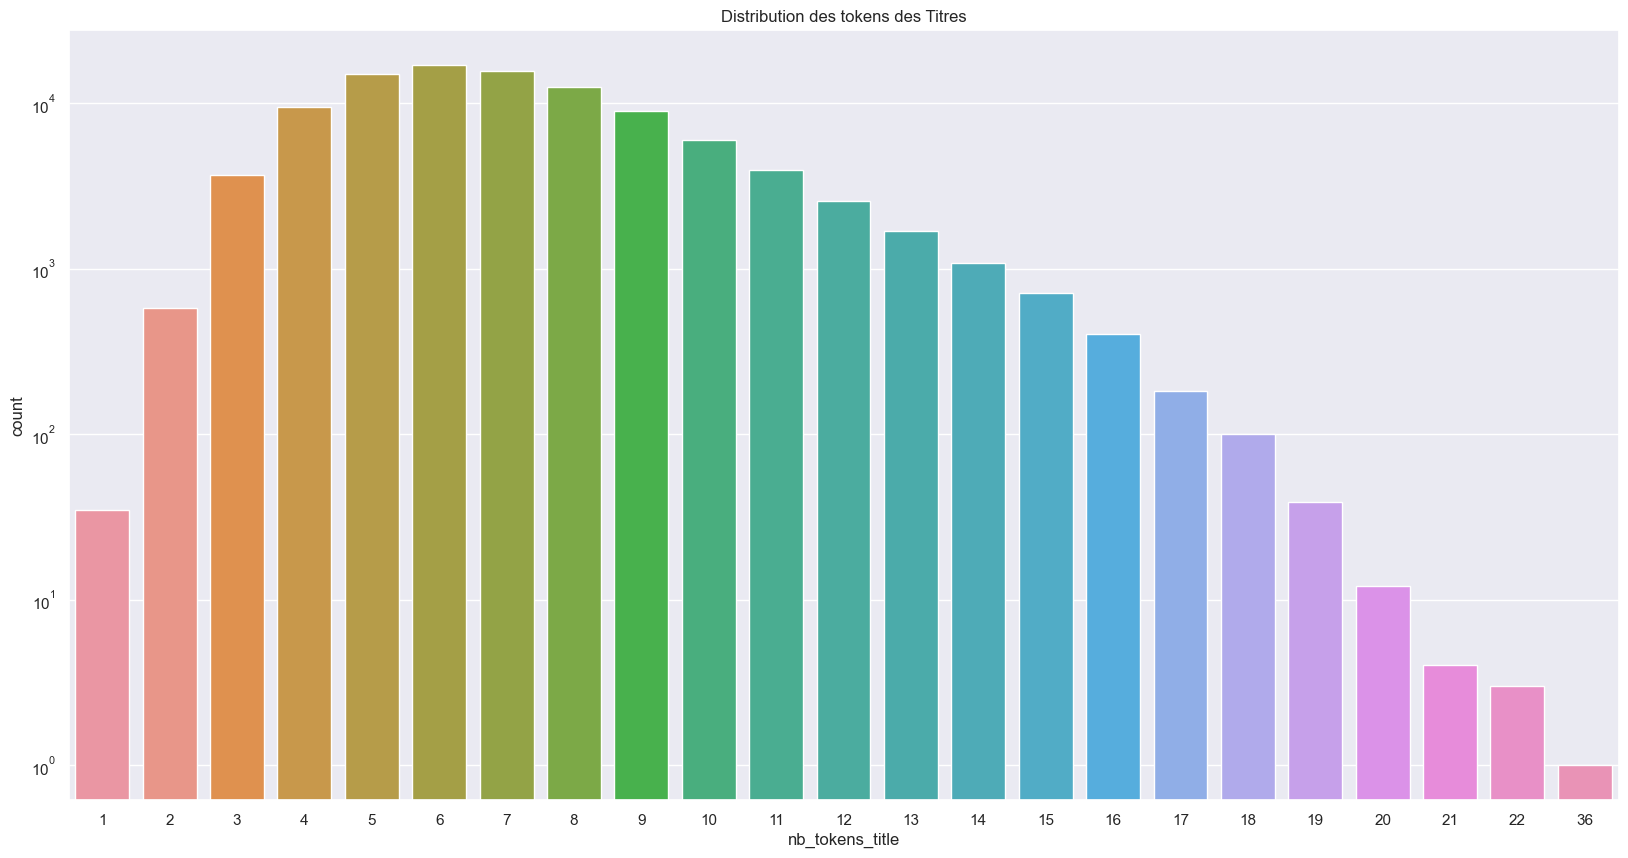

In [95]:
# Titles Countplot 
fig = plt.figure(figsize=(20, 10))
g = sns.countplot(x=df.nb_tokens_title)
g.set_yscale("log")
plt.title("Distribution des tokens des Titres")
plt.show()

In [96]:
df.nb_tokens_title.describe()

count     99986
unique       23
top           6
freq      17091
Name: nb_tokens_title, dtype: int64

In [97]:
df.loc[df.nb_tokens_title == 0]

,Title,Body,Tags,title_bow,body_bow,tag_bow,body_bow_lem,body_dl,nb_tokens_title,nb_tokens_body,nb_tags,nb_tokens_shared,nb_tags_shared_Title,nb_tags_shared_Body
Id,,,,,,,,,,,,,,


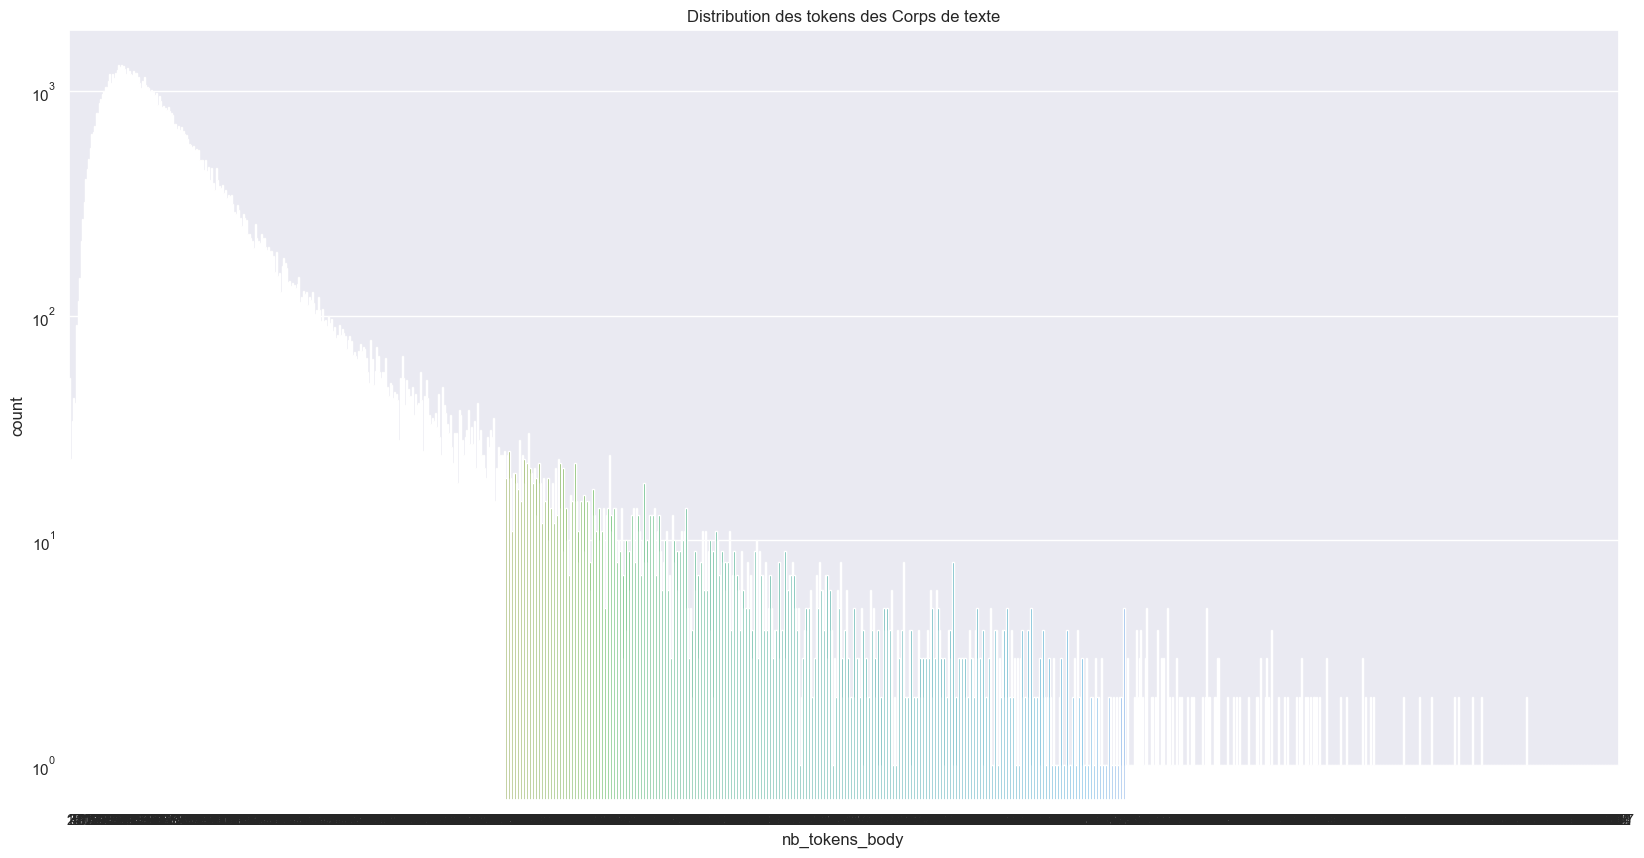

In [98]:
# Bodies Countplot 
fig = plt.figure(figsize=(20, 10))
g = sns.countplot(x=df.nb_tokens_body)
g.set_yscale("log")
plt.title("Distribution des tokens des Corps de texte")
plt.show()

In [99]:
df.nb_tokens_body.describe()

count     99986
unique     1033
top          36
freq       1309
Name: nb_tokens_body, dtype: int64

In [100]:
df.loc[df.nb_tokens_body == 0]

,Title,Body,Tags,title_bow,body_bow,tag_bow,body_bow_lem,body_dl,nb_tokens_title,nb_tokens_body,nb_tags,nb_tokens_shared,nb_tags_shared_Title,nb_tags_shared_Body
Id,,,,,,,,,,,,,,


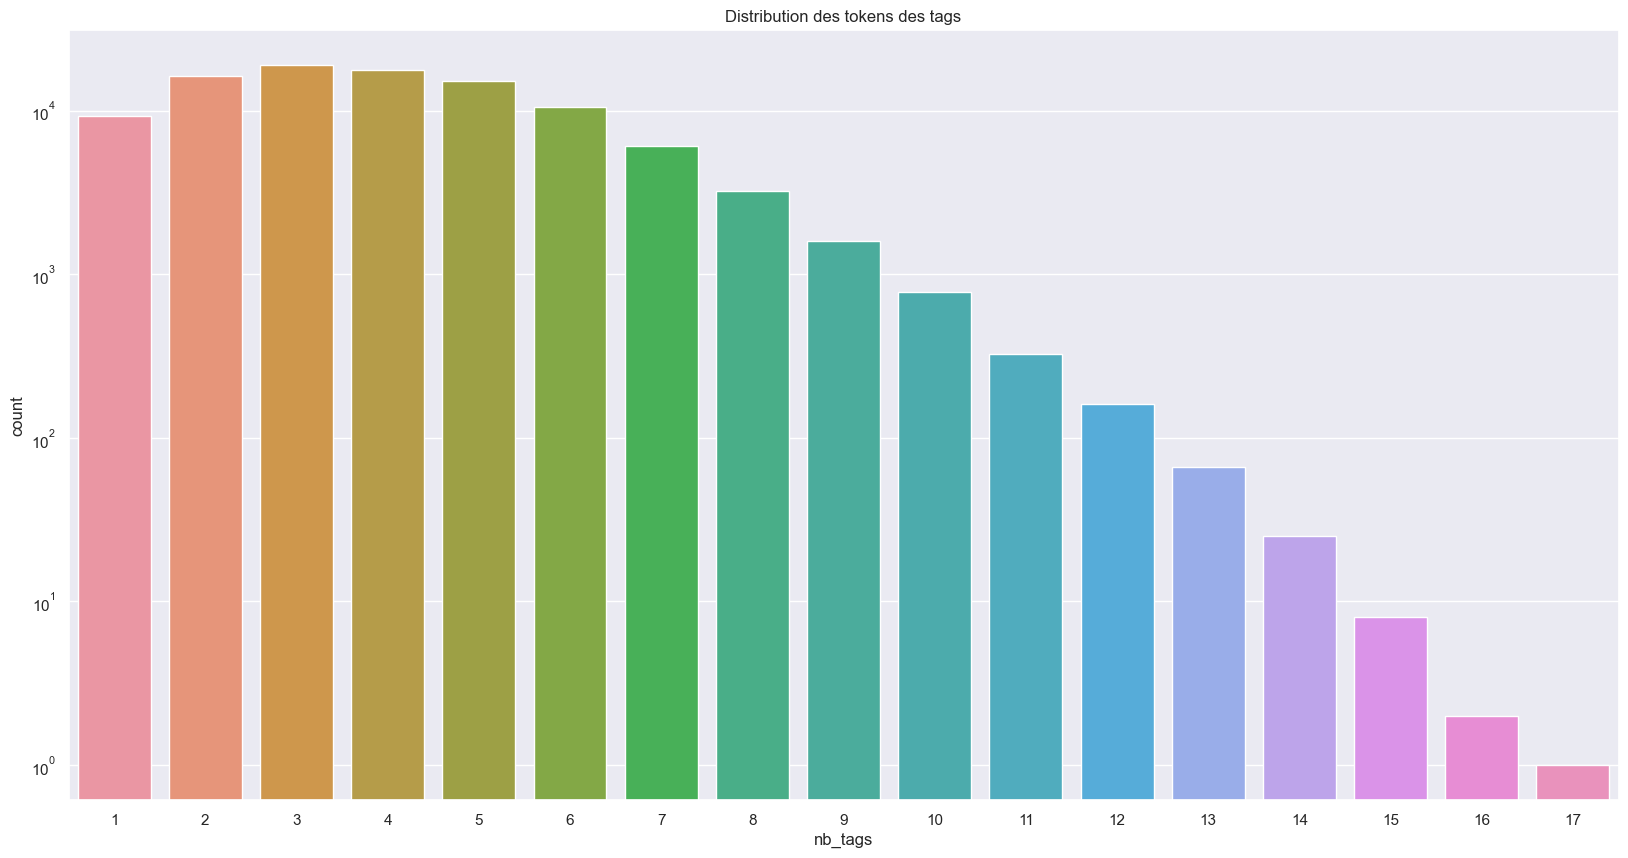

In [101]:
# Tags Countplot 
fig = plt.figure(figsize=(20, 10))
g = sns.countplot(x=df.nb_tags)
g.set_yscale("log")
plt.title("Distribution des tokens des tags")
plt.show()

In [102]:
df.loc[df.nb_tags == 0]

,Title,Body,Tags,title_bow,body_bow,tag_bow,body_bow_lem,body_dl,nb_tokens_title,nb_tokens_body,nb_tags,nb_tokens_shared,nb_tags_shared_Title,nb_tags_shared_Body
Id,,,,,,,,,,,,,,


### <a name="C3.3.3">3.3.2 Nettoyage aprés analyse</a>

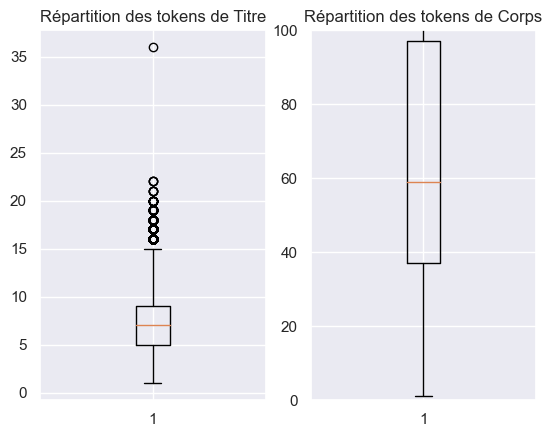

In [103]:
plt.subplot(121)
plt.boxplot(df.nb_tokens_title)
plt.title('Répartition des tokens de Titre')

plt.subplot(122)
plt.boxplot(df.nb_tokens_body)
plt.title('Répartition des tokens de Corps')
plt.ylim(0,100)

plt.show()

In [105]:
len(df)

99986

In [106]:
df = df[(df['nb_tokens_title']>=3)&(df['nb_tokens_title']<=13)]
df = df[(df['nb_tokens_body']>=10)&(df['nb_tokens_body']<=80)]

In [107]:
len(df)

64175

In [108]:
# list of tags tokens
#Tag_tokens = [token for token in df.tag_bow]

df_word_freq = pd.DataFrame(nltk.FreqDist(Tag_tokens).items(),columns=['tag', 'frequency']).set_index('tag')
df_word_freq.sort_values("frequency", ascending=False, inplace=True)
df_word_freq.head(100)

,frequency
tag,
python,17814
javascript,9474
c,8329
js,6283
google,5753
...,...
string,580
entity,575
functions,574


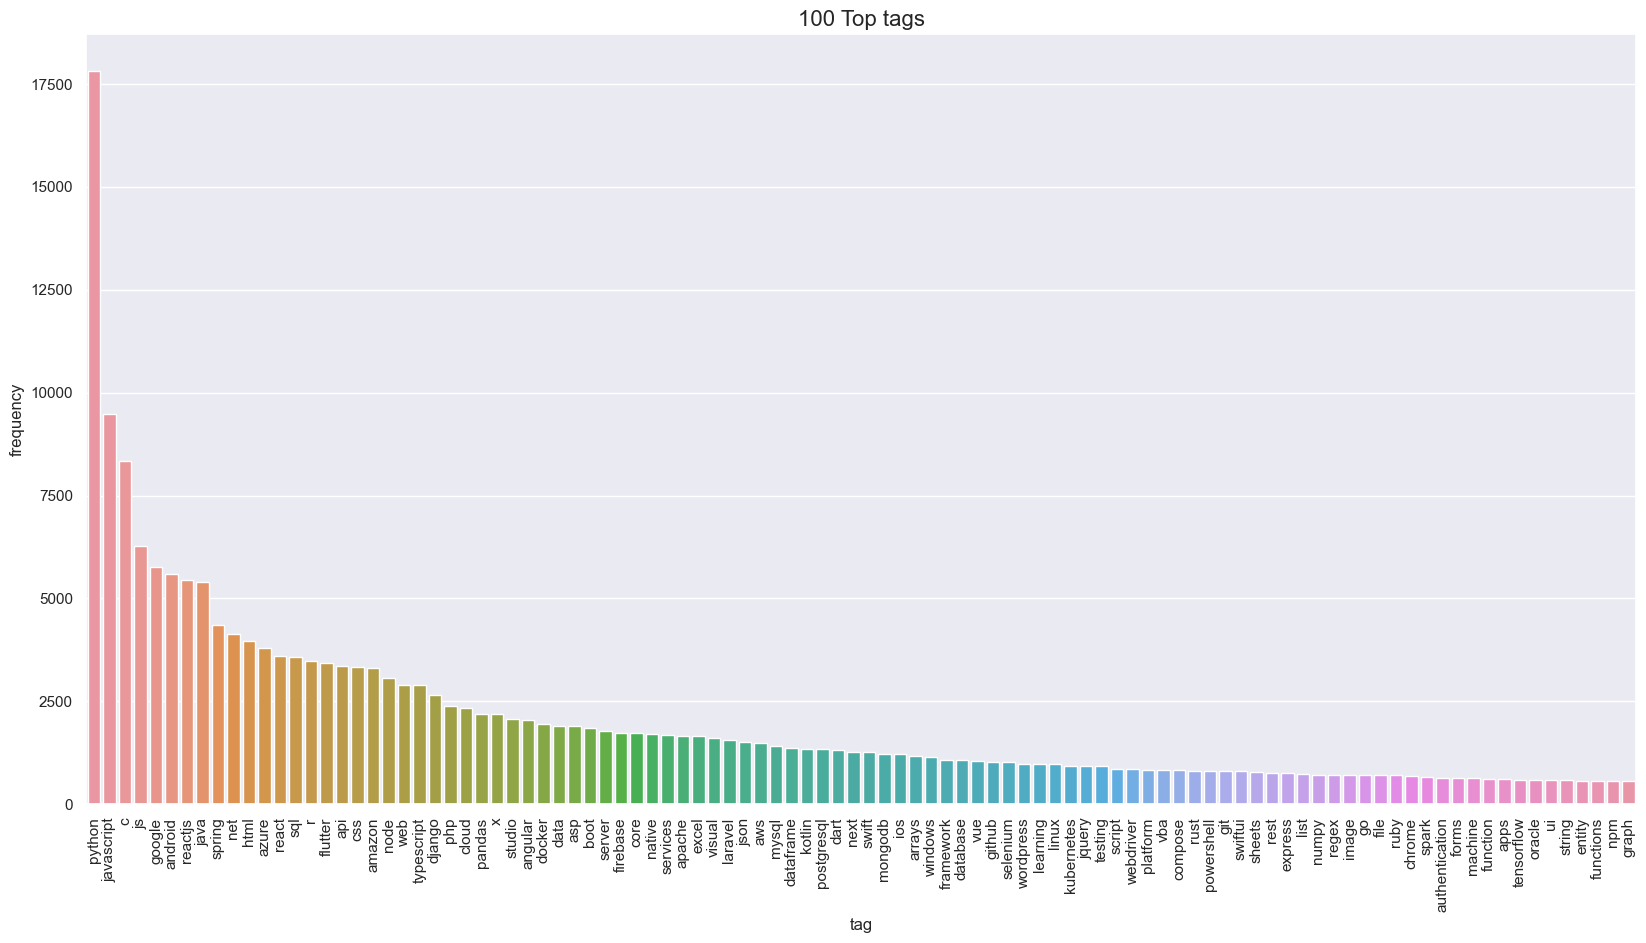

In [109]:
fig = plt.figure(figsize=(20, 10))
sns.barplot(data=df_word_freq.iloc[0:100, :],
            x=df_word_freq.iloc[0:100, :].index,y="frequency")
plt.xticks(rotation=90)
plt.title("100 Top tags",fontsize=16)
plt.show()

In [114]:
def filter_tags(sentence, tags_to_keep):
    raw = nltk.word_tokenize(sentence)
    tokens = [w for w in raw if w in  df_word_freq[0:tags_to_keep].index ]
    return tokens 

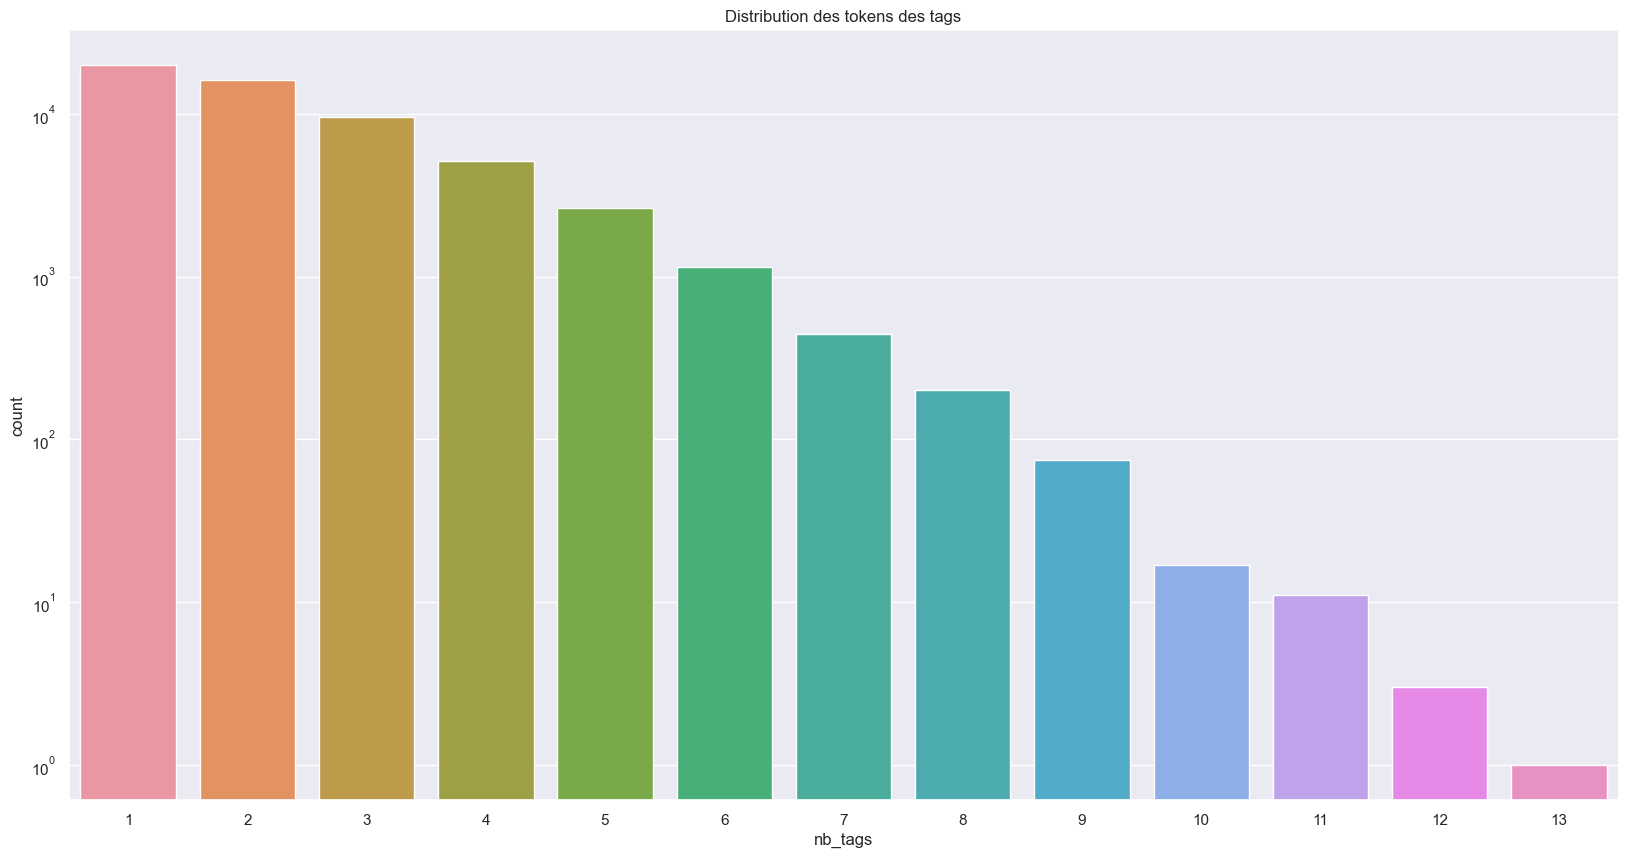

In [115]:
# filtering df from the top 100 tags
df['tag_tok'] = df.tag_bow.apply(lambda sentence : filter_tags(sentence, 100))

# update the number of tags on each raw
df['nb_tags'] = [len(raw) for raw in df.tag_tok]

# delete the raws with zero Tags
df = df[df['nb_tags']>0]

# Tags Countplot 
fig = plt.figure(figsize=(20, 10))
g = sns.countplot(x=df.nb_tags)
g.set_yscale("log")
plt.title("Distribution des tokens des tags")
plt.show()

In [117]:
len(df)

55308

# <a name="C4">4. Sauvegarde du jeu de données nettoyé</a>

In [118]:
col = ['Title', 'Body','Tags','title_bow', 'body_bow', 'tag_bow', 'body_bow_lem', 'body_dl']
df[col].to_csv("data/cleaned/df_100_tags.csv", index=False,header=True,sep=';')

In [121]:
# filtering df from the top 25 tags
df['tag_tok'] = df.tag_bow.apply(lambda sentence : filter_tags(sentence, 25))

# update the number of tags on each raw
df['nb_tags'] = [len(raw) for raw in df.tag_tok]

# delete the raws with zero Tags
df = df[df['nb_tags']>0]
len(df)


44902

In [122]:
df[col].to_csv("data/cleaned/df_25_tags.csv", index=False,header=True,sep=';')